In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import gzip
import copy
import os
import pickle as pk
import heapq as hp


import networkx as nx
from networkx.algorithms import bipartite, components, shortest_paths



# I - Importing the datasets, cleaning, transforming

## Import

**Instacart datasets** (provided) : https://www.instacart.com/datasets/grocery-shopping-2017 . The instacart datasets consist in a group of 5 different datasets, each adopting a different point of view 
* "products", a dataset based on the product point of view, describing to which aisle and department it belongs to
* "aisles", a dataset that enriches "products" by describing each aisle formally
* "departments", a dataset that enriches "products" by describing each department formally
* "orders", a dataset based on the order point of view, describing when it was purchased
* "order_products_prior", a dataset based on both the order and product point of view, associating each order with the products that were purchased

After loading the datasets, we verify whether there are any missing values. 

In [2]:
products = pd.read_csv('data/products.csv', sep=',')
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [3]:
products.isnull().values.any()

False

In [4]:
aisles = pd.read_csv('data/aisles.csv', sep=',')
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [5]:
aisles.isnull().values.any()

False

In [6]:
departments = pd.read_csv('data/departments.csv', sep=',')
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [7]:
departments.isnull().values.any()

False

In [8]:
orders = pd.read_csv('data/orders.csv', sep=',')
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [9]:
orders.isnull().values.sum()==orders['days_since_prior_order'].isnull().values.sum()

True

The missing values in _orders_ appear to correspond to the date of "previous order", when it happens to be the first one.

In [10]:
history = pd.read_csv('data/order_products__prior.csv', sep=',')
history.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [11]:
history.isnull().values.any()

False

There are no unexpected NaN values in any of the Instacart datasets.

## Gathering all datasets

**Create a dataset with all useful information gathered : products_litteral**

We first add the names of the aisle and department in the _products_ dataset, instead of the ID, by merging the datasets :

In [12]:
products_litteral = pd.merge(pd.merge(products, aisles, on='aisle_id'), departments, on='department_id').drop(['aisle_id', 'department_id'], axis=1)
products_litteral.head()

,product_id,product_name,aisle,department
0,1,Chocolate Sandwich Cookies,cookies cakes,snacks
1,78,Nutter Butter Cookie Bites Go-Pak,cookies cakes,snacks
2,102,Danish Butter Cookies,cookies cakes,snacks
3,172,Gluten Free All Natural Chocolate Chip Cookies,cookies cakes,snacks
4,285,Mini Nilla Wafers Munch Pack,cookies cakes,snacks


In [13]:
products_litteral.to_pickle('products_litteral.pk')

In [14]:
products_litteral = pd.read_pickle('products_litteral.pk')

**Dealing with 'missing' values**


In [15]:
missing = products_litteral[(products_litteral.department =='missing') | (products_litteral.aisle=='missing')]
missing.head(20)

,product_id,product_name,aisle,department
42813,38,Ultra Antibacterial Dish Liquid,missing,missing
42814,72,Organic Honeycrisp Apples,missing,missing
42815,110,Uncured Turkey Bologna,missing,missing
42816,297,"Write Bros Ball Point Pens, Cap-Pen, Medium (1...",missing,missing
42817,417,Classics Baby Binks Easter Chocolate Bunny,missing,missing
42818,437,Strawberry Cheesecake Nonfat Yogurt,missing,missing
42819,440,Crossovers Olive Thyme Almond,missing,missing
42820,472,Fancy Diced Hot Chilies,missing,missing
42821,491,Pompelmo Water,missing,missing
42822,556,Bake & Break Cheese Garlic Loaf,missing,missing


We can see many products don't have any name for the aisle and/or department

In [16]:
print("There are %d products with 'missing' aisle/department. This represent %0.1f%% of the products." %(missing.shape[0], missing.shape[0]/products_litteral.shape[0]*100))

There are 1258 products with 'missing' aisle/department. This represent 2.5% of the products.


The unlabelled products seem to come from many different categories, and represent a small fraction of our dataset. We decide  to let them in our work dataset, but to treat them carefully.

# II - Basic Statistical analysis

A first way to get familiar with the data we have to treat is to derive basic statistics between features. In this part, we do so by joining our 5 datasets and ploting distributions.

### Number of products per Aisle and Department (products diversity)

We first visualize the products per aisle and per department to detect any inconsistency

In [17]:
per_dpt=products_litteral[['product_id', 'department']].groupby('department').count().sort_values(by='product_id', ascending=False)
per_dpt.columns=['COUNT']

Text(0, 0.5, 'Departments')

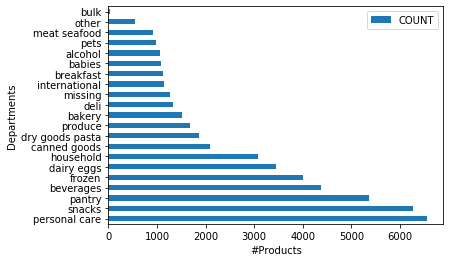

In [18]:
ax = per_dpt.plot(kind='barh')
ax.set_xlabel('#Products')
ax.set_ylabel('Departments')

In [19]:
per_dpt.head()

,COUNT
department,
personal care,6563
snacks,6264
pantry,5371
beverages,4365
frozen,4007


The 'personal care' department has the largest choice of products, just followed by the 'snacks' one.

In [20]:
per_aisle=products_litteral[['product_id', 'aisle']].groupby('aisle').count().sort_values(by='product_id', ascending=False)
per_aisle.columns=['COUNT']


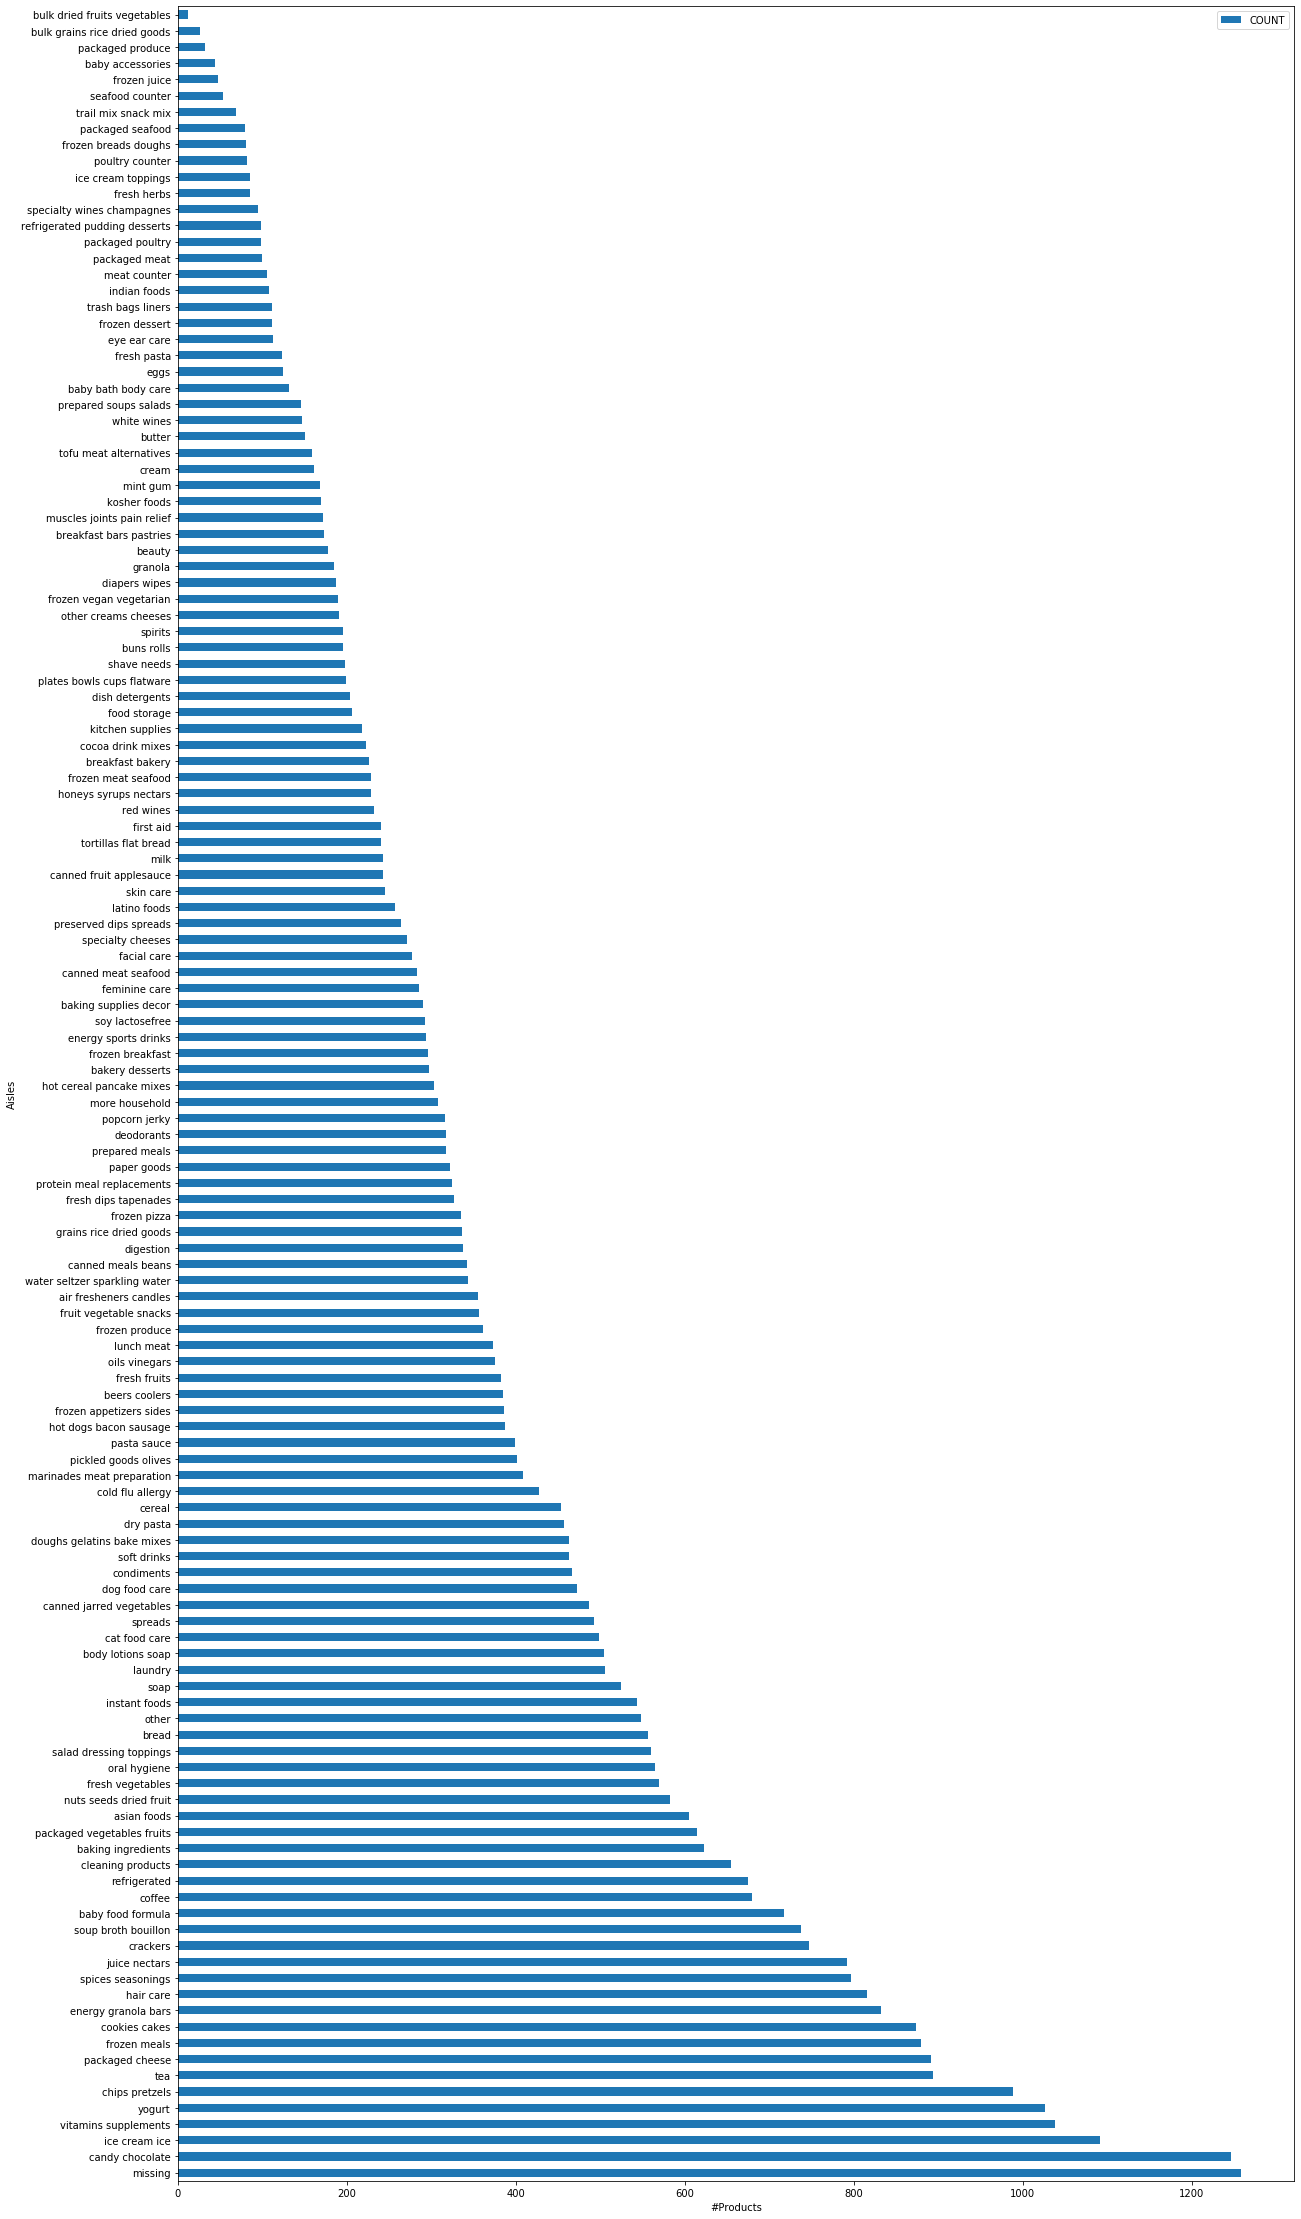

In [21]:
ax = per_aisle.plot(kind='barh', figsize=(20,40))
ax.set_xlabel('#Products')
ax.set_ylabel('Aisles')
plt.show()

In [22]:
per_aisle.head()

,COUNT
aisle,
missing,1258
candy chocolate,1246
ice cream ice,1091
vitamins supplements,1038
yogurt,1026


'Candy chocolate' and 'ice cream ice' have the largest choices of products. We can see that none of the 10 first aisles are in the 'Personal care' departement. However, this department is the lagest in terms of products number because it offers a diverse choice of aisles instead of one aisle with many products, as 'Snacks'.

### Number of orders

Let's complete our 'useful' dataset with the information about the number of orders per product

In [23]:
number_of_order_per_product = history[['order_id','product_id']].groupby('product_id').count().sort_values(by='order_id', ascending=False)
number_of_order_per_product = number_of_order_per_product.rename(columns={"order_id" : "number_of_orders"})
number_of_order_per_product.head()

,number_of_orders
product_id,
24852,472565
13176,379450
21137,264683
21903,241921
47209,213584


In [24]:
products_litteral.head()

,product_id,product_name,aisle,department
0,1,Chocolate Sandwich Cookies,cookies cakes,snacks
1,78,Nutter Butter Cookie Bites Go-Pak,cookies cakes,snacks
2,102,Danish Butter Cookies,cookies cakes,snacks
3,172,Gluten Free All Natural Chocolate Chip Cookies,cookies cakes,snacks
4,285,Mini Nilla Wafers Munch Pack,cookies cakes,snacks


In [25]:
number_of_order_per_product.head()

,number_of_orders
product_id,
24852,472565
13176,379450
21137,264683
21903,241921
47209,213584


In [26]:
products_litteral = pd.merge(products_litteral, number_of_order_per_product, on='product_id')
products_litteral.head()

,product_id,product_name,aisle,department,number_of_orders
0,1,Chocolate Sandwich Cookies,cookies cakes,snacks,1852
1,78,Nutter Butter Cookie Bites Go-Pak,cookies cakes,snacks,11
2,102,Danish Butter Cookies,cookies cakes,snacks,185
3,172,Gluten Free All Natural Chocolate Chip Cookies,cookies cakes,snacks,97
4,285,Mini Nilla Wafers Munch Pack,cookies cakes,snacks,156


**Number of orders per product**

In [27]:
products_litteral.sort_values(by='number_of_orders', ascending=False).head()

,product_id,product_name,aisle,department,number_of_orders
42491,24852,Banana,fresh fruits,produce,472565
42399,13176,Bag of Organic Bananas,fresh fruits,produce,379450
42466,21137,Organic Strawberries,fresh fruits,produce,264683
41417,21903,Organic Baby Spinach,packaged vegetables fruits,produce,241921
42662,47209,Organic Hass Avocado,fresh fruits,produce,213584


Bananas are the most sold product.

Text(0.5, 0, 'Departments')

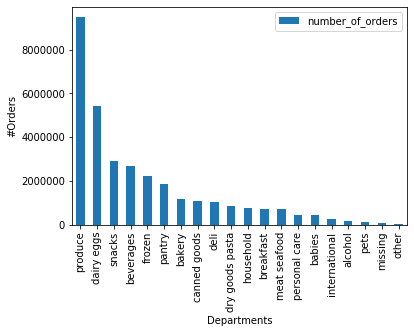

In [28]:
order_by_department = products_litteral[['department', 'number_of_orders']].groupby('department').sum().sort_values(by='number_of_orders', ascending=False).head(20)
ax = order_by_department.plot(kind='bar')
ax.set_ylabel('#Orders')
ax.set_xlabel('Departments')

Text(0.5, 0, 'Aisles')

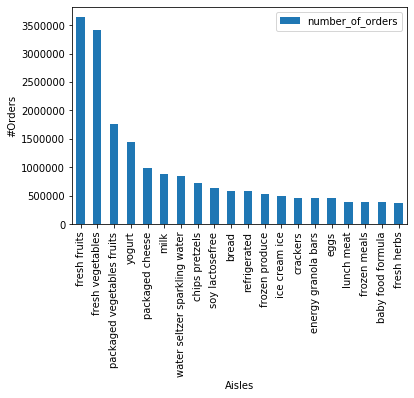

In [29]:
order_by_aisle = products_litteral[['aisle', 'number_of_orders']].groupby('aisle').sum().sort_values(by='number_of_orders', ascending=False).head(20)
ax = order_by_aisle.plot(kind='bar')
ax.set_ylabel('#Orders')
ax.set_xlabel('Aisles')

Produce, followed by eggs are the departments with most sales. For the aisles, it is fresh fruits and vegetables that take the lead. Interestingly, snacks, which is the aisle with mostthe largest choice of products, is only the third in number of sales.

### Timing of orders

In [30]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [31]:
days_of_orders = orders[['order_id', 'order_dow']].groupby('order_dow').count()
days_of_orders = days_of_orders.rename(columns={"order_id" : "number_of_orders"})
days_of_orders

,number_of_orders
order_dow,
0,600905
1,587478
2,467260
3,436972
4,426339
5,453368
6,448761


In [32]:
days_of_orders.index = ['Saturday','Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']

We found in some metadata that 0 corresponds to Saturday. This is not surprising as we expect that customers have more time to purchase during weekends.

Text(0, 0.5, '#Orders')

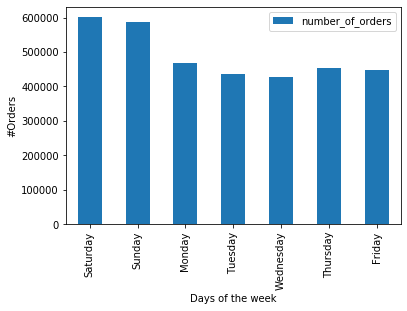

In [33]:
ax = days_of_orders.plot(kind='bar')
ax.set_xlabel('Days of the week')
ax.set_ylabel('#Orders')

Text(0, 0.5, '#Orders')

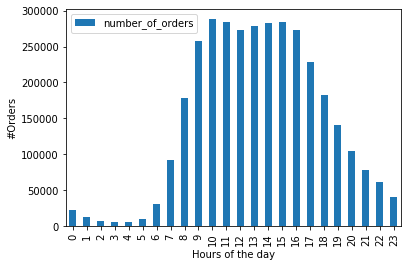

In [34]:
hours_of_orders = orders[['order_id', 'order_hour_of_day']].groupby('order_hour_of_day').count()
hours_of_orders = hours_of_orders.rename(columns={"order_id" : "number_of_orders"})
ax = hours_of_orders.plot(kind='bar')
ax.set_xlabel('Hours of the day')
ax.set_ylabel('#Orders')

People tend to order during working hours (between 8 a.m. and 20 p.m.), and at the beginning of the week (Monday and Tuesday).

### Multiple orders

Text(0, 0.5, '#of such orders')

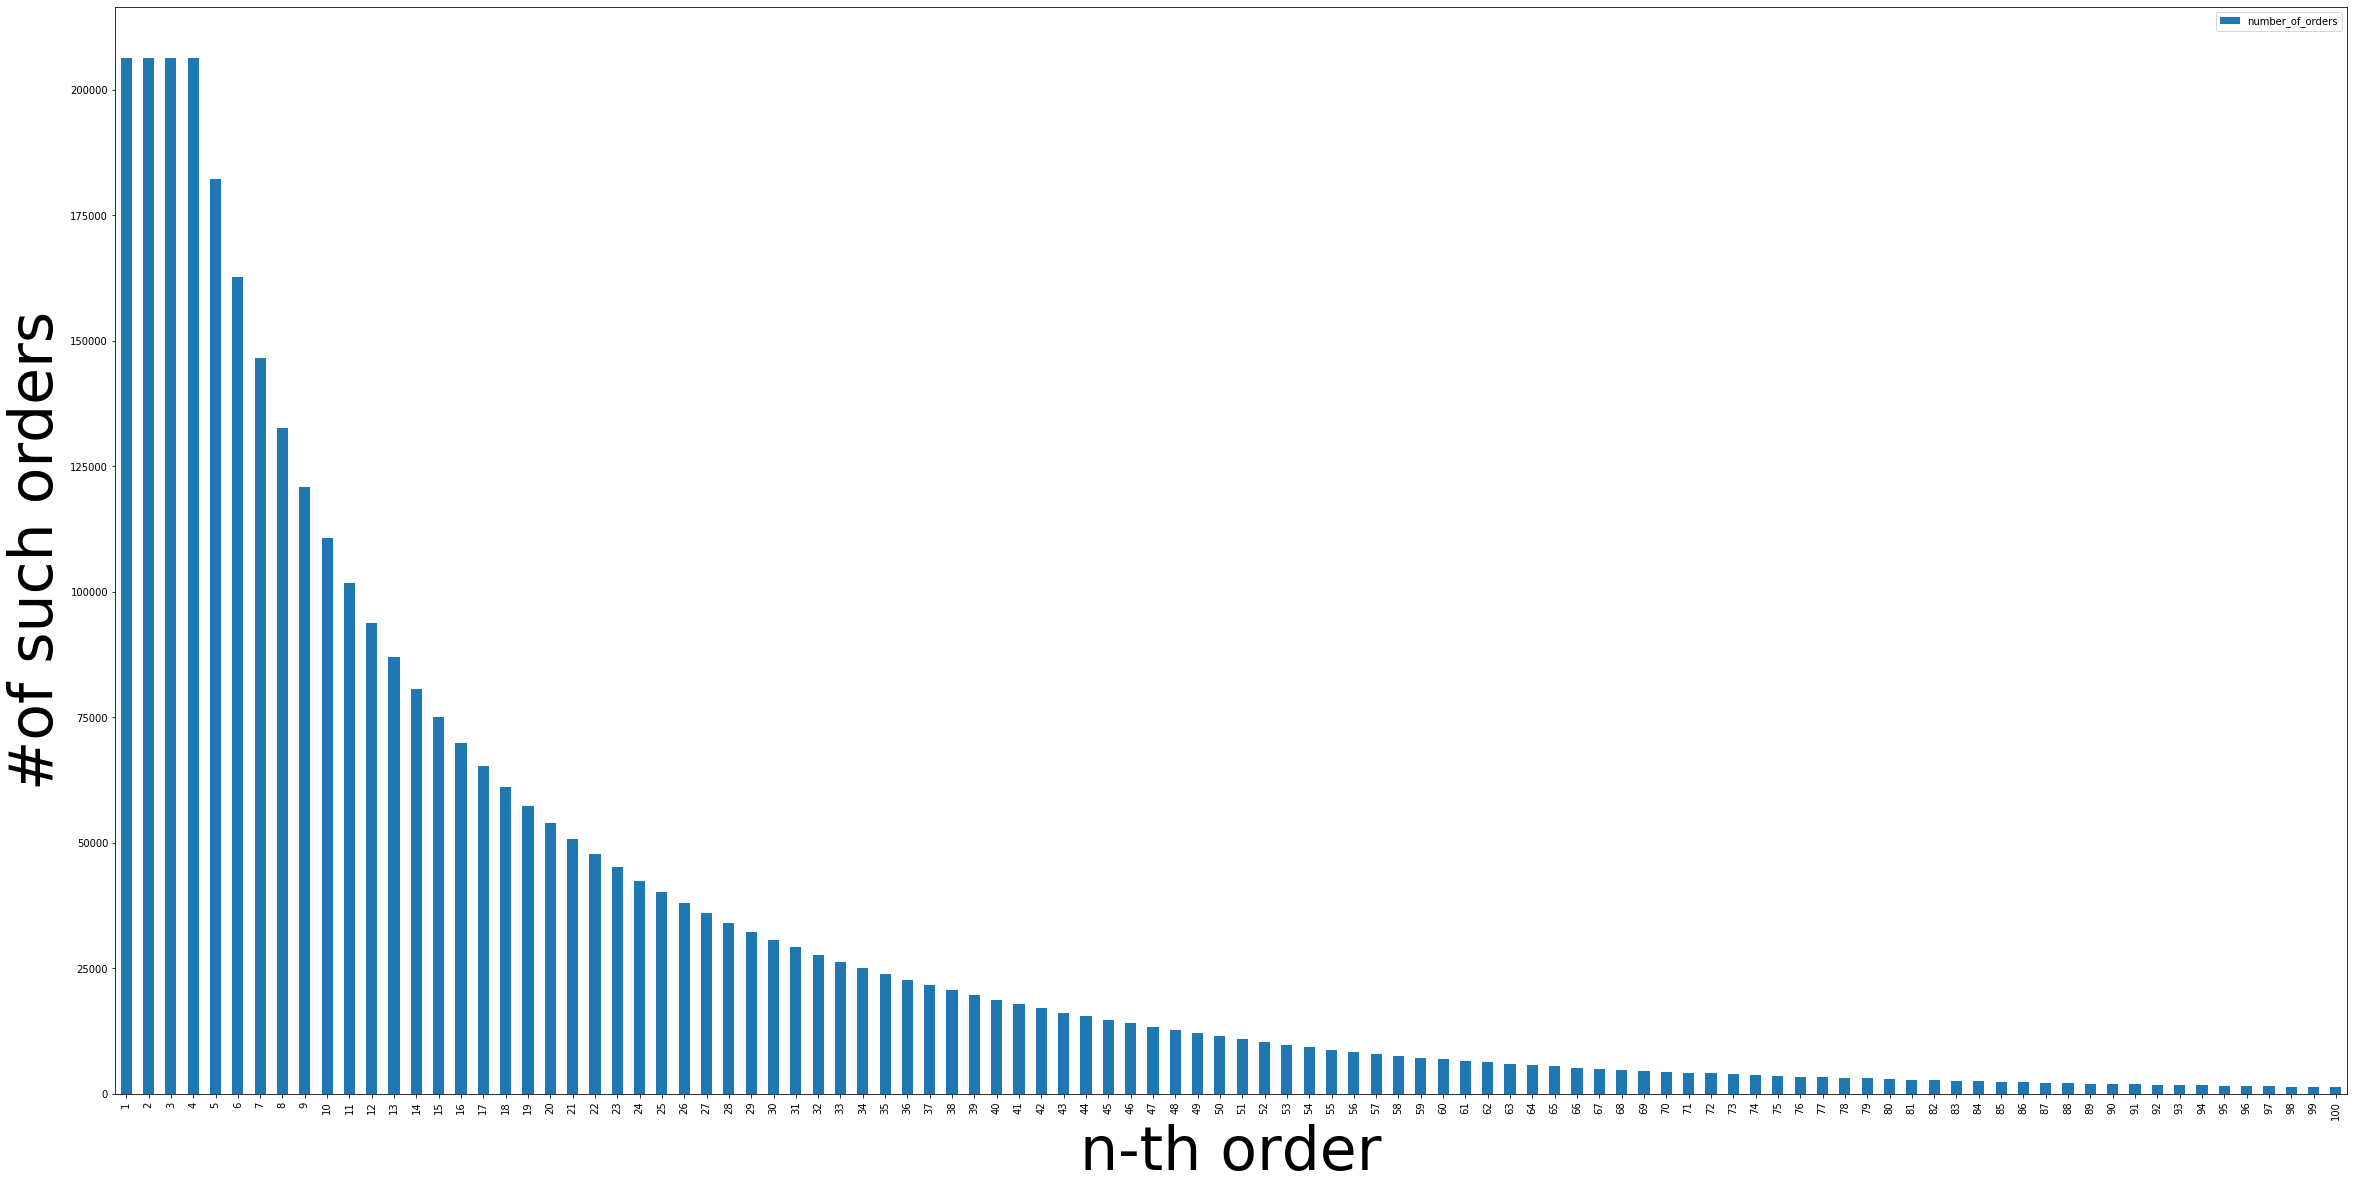

In [35]:
number_of_orders = orders[['order_id', 'order_number']].groupby('order_number').count() #Order_number represents the number of the order with respect to a particular customer
number_of_orders = number_of_orders.rename(columns={"order_id" : "number_of_orders"})
ax = number_of_orders.plot(kind='bar', figsize=(40,20))
ax.set_xlabel('n-th order',fontsize=60)
ax.set_ylabel('#of such orders',fontsize=60)

Most of the orders are first-time orders. We can see it from a different perspective with an user-centric approach.

In [36]:
max_orders = orders[['user_id', 'order_number']].groupby('user_id').max()
max_orders = max_orders.rename(columns={"order_number" : "max_orders"})

Text(0, 0.5, '#Users')

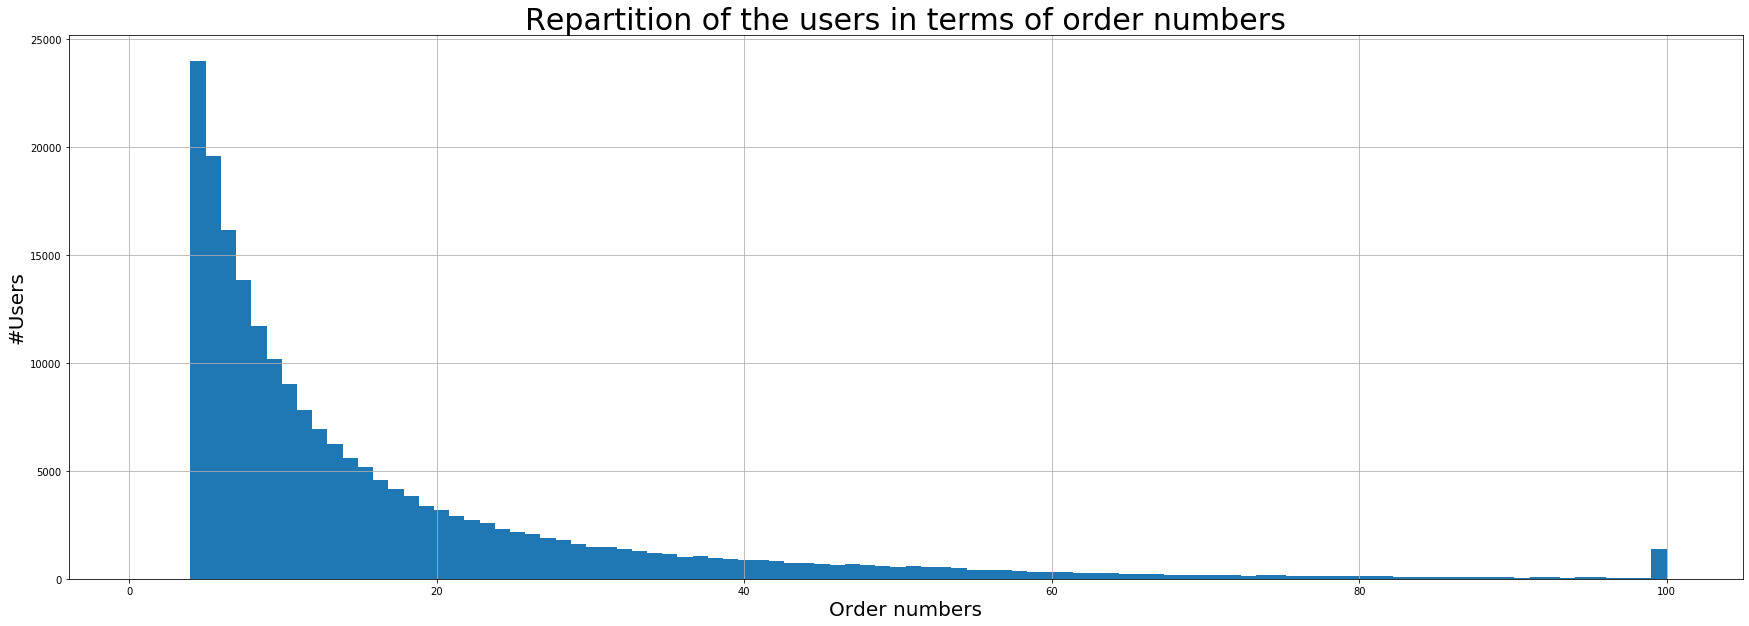

In [37]:
m = int(max_orders.max())
max_orders.hist(range=(1, m), bins = m, figsize=(30,10))
plt.title('Repartition of the users in terms of order numbers',fontsize=30)
plt.xlabel('Order numbers',fontsize=20)
plt.ylabel('#Users',fontsize=20)

Most of the consumers only order 4 times. None of them order less, which is surprising. We can hypothesize that we were provided with a dataset containing only user data , and the distribution is then logarithmic We can see a high pic at 100 orders, which correspond to "100 and more". 

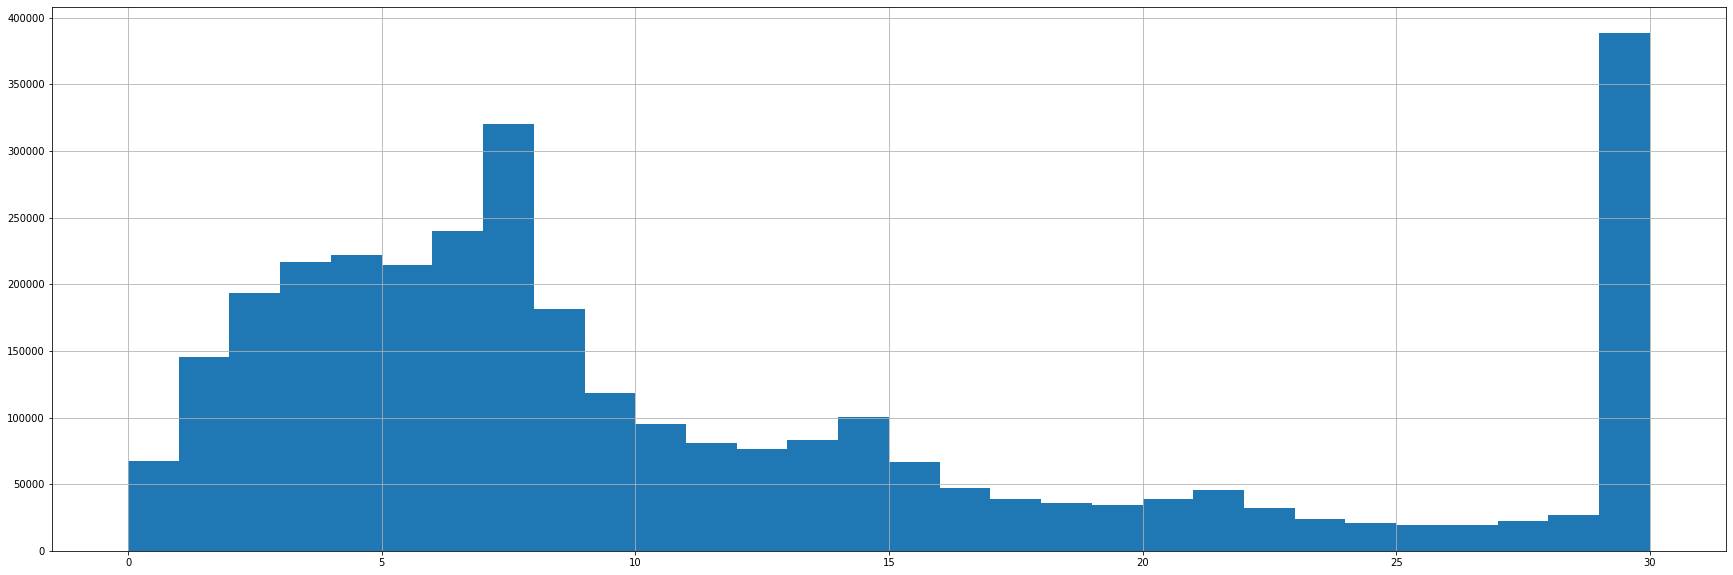

In [38]:
m = int(orders['days_since_prior_order'].max())
orders['days_since_prior_order'].hist(bins = m, figsize=(30,10))

We can see a high pick in "30 days", which corresponds to "30 and more", thus unregular users. Otherwise, most consumer reorder within 10 days and we can see a pick in 7 days. This means many users order at the same day of he week.

### Reordering

We finally want to merge our history and orders datasets to gather all informations about reordering. This is the final dataset we'll use.

In [39]:
history.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [40]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [41]:
history_users = pd.merge(history, orders, on='order_id')
history_users.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


# III - Clustering of the users

Our objective is to differentiate the users in a healthiness scale. To do so, we will cluster them depending on the number of products they buy in each aisles. Thus, we expect for instance that the users buying many vegetables will be in a different cluster than the one buying frozen meals, or many snacks.

## Creation of the matrix 

The goal of the next cell is to create a matrix M such that M [ i ] [ j ] = proportion of products user n°i bought in aisle n°j. This will enable a user representation in vector form that will be used to form user clusters.

In [45]:
# Merge useful information
consumptions = pd.merge(history, orders, on="order_id")[['user_id','product_id']]
consumptions_with_details = pd.merge(consumptions,products, on="product_id")[['user_id','product_id','aisle_id','department_id']]
max_user_id=206209

# Split the dataset to avoid memory errors
consumptions_1 = consumptions_with_details[consumptions_with_details.user_id<max_user_id//2]
consumptions_2 = consumptions_with_details[consumptions_with_details.user_id>=max_user_id//2]
assert(len(consumptions_with_details)==len(consumptions_1)+len(consumptions_2))

# Agglomerate to have number of consumptions of each consumer in each aisle
consumption_aisle_1 = consumptions_1[["user_id","product_id", "aisle_id"]].groupby(['user_id','aisle_id']).agg({'product_id': "count"})
consumption_aisle_2 = consumptions_2[["user_id","product_id", "aisle_id"]].groupby(['user_id','aisle_id']).agg({'product_id': "count"})

max_aisle_id = 134
# Create empty matrix
def init_matrix_aisle():
    np1 = []
    for w in range(max_user_id+1):
        np1.append([0 for x in range(max_aisle_id+1)])
    return np1


# Turns dataset into matrix
def to_tab_vect(consumption,mat=init_matrix_aisle()):
    '''Returns the matrix M such that M[user][aisle] = number of distinct products bought by user in aisle'''
    n=0
    n_pairs = len(consumption)
    for (user, aisle) in consumption.index :
        n+=1
        mat[user][aisle] = consumption.product_id[(user, aisle)]
        if n%250000==0 : print(str(round(100*(n/n_pairs),1))+ "% processed")
    print('Done !')
    return mat

# Complete the matrix
user_matrix = to_tab_vect(consumption_aisle_1)
user_matrix = to_tab_vect(consumption_aisle_2, user_matrix)

# Save the results
f=open("user_matrix","wb")
pk.dump(user_matrix,f)
f.close()

## Dimensionnality reduction

The number of features being very high, we need to reduce it in order to cluster efficiently. We decided to proceed to a dimensionnality reduction by Principal Components Analysis.

In [46]:
user_matrix = np.array(user_matrix)

We will use a matrix normalized by the number of products bought by each user. So only the repartition of products by aisles will be considered, not the number.

In [47]:
row_sums = user_matrix.sum(axis=1) #Normalize on the rows (rows_sum -> 1)
norm_matrix = user_matrix / row_sums[:, np.newaxis]
for (i, l) in enumerate(norm_matrix) :
    if str(l[0])=="nan":
        for k in range(0, len(norm_matrix[0])):
            norm_matrix[i][k]=0

C:\Users\eloi0\Anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [50]:
from sklearn.decomposition import PCA
pca = PCA(random_state=0) 
pca.fit(norm_matrix)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=0,
    svd_solver='auto', tol=0.0, whiten=False)

In [51]:
reduc_matrix = pca.transform(norm_matrix)

Determine the right number of dimensions as a trade-off between number of dimensions and loss of variance.

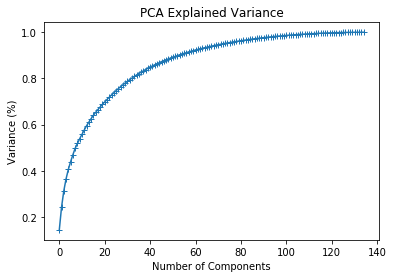

In [52]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='+')
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('PCA Explained Variance')
plt.show()

The dimension is choosen at the 'elbow' : 30.

In [53]:
pca = PCA(n_components=30, random_state=0)
reduc_matrix = pca.fit_transform(norm_matrix)

Let's have a look at the new dimension vectors by looking at the features impacting them the most :

In [54]:
aisle_list = list(aisles.aisle)
i=0
for d in pca.components_ :
    print("dimension" + str(i)+" ") 
    i+=1
    if abs(np.max(d))>=abs(np.min(d)):
        print(str(aisle_list[np.argmax(d)-1]) + " " + str(np.max(d)))
    else :
        print(str(aisle_list[np.argmin(d)-1])+" "+str(np.min(d)))

dimension0 
fresh vegetables 0.7076243447969971
dimension1 
fresh fruits 0.75334063452083
dimension2 
water seltzer sparkling water 0.9312238961726426
dimension3 
packaged produce 0.7982139440600137
dimension4 
yogurt 0.7631544806665144
dimension5 
packaged vegetables fruits 0.7993175459767233
dimension6 
milk 0.7211667189798492
dimension7 
milk 0.5998425060490342
dimension8 
ice cream ice 0.8680543212570417
dimension9 
refrigerated 0.7799562332595277
dimension10 
chips pretzels 0.7043256422240006
dimension11 
soy lactosefree 0.6117600890395932
dimension12 
frozen meals 0.7672042840091953
dimension13 
soy lactosefree 0.6206002223528142
dimension14 
energy granola bars 0.8148621586758874
dimension15 
baby food formula 0.8640871535928624
dimension16 
frozen produce 0.8553480505673058
dimension17 
candy chocolate 0.731447608264283
dimension18 
cereal 0.5131929807022032
dimension19 
bread 0.544252210705195
dimension20 
juice nectars 0.859506292658131
dimension21 
cream 0.524187333069064
di

We can see that the aisles determining the first independant dimensions (fresh vegetables, fresh fruits, water, packaged produces) may be related to healthiness. 

Determine the right number of clusters (k)

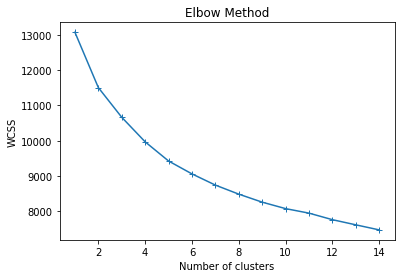

In [56]:
from sklearn.cluster import KMeans

wcss=[]
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(reduc_matrix)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 15), wcss, marker='+')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

The number of clusters k is choosen at the elbow : 5.

In [57]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(reduc_matrix)

In [59]:
def get_cluster_size(clustering, nb_clusters,matrix=user_matrix) :
    for k in range(nb_clusters):
        number_users_in_cluster = 0.
        for user_index in range(1,len(matrix)) :
            if kmeans.labels_[user_index]==k :
                number_users_in_cluster+=1
        print(number_users_in_cluster)
        
get_cluster_size(kmeans, 5, reduc_matrix)

7931.0
55723.0
99059.0
5345.0
38151.0


## Analyse the clusters

**Look at centroids distance**

In [60]:
kmeans.cluster_centers_

array([[-6.08397412e-03,  1.30834243e-01,  4.86830103e-03,
         2.30406130e-01,  1.10280480e-01, -2.29702910e-02,
         1.74930549e-04, -6.47930576e-03,  7.83211321e-03,
         3.01967927e-03,  1.11850012e-03, -1.98848887e-03,
         1.03499065e-03,  4.33513869e-03,  1.80647756e-03,
         4.54508781e-03, -1.01108757e-03, -2.48875112e-03,
        -1.17378569e-03,  1.54540757e-03, -1.09782451e-03,
        -1.51944362e-03, -8.16447431e-04,  3.59673622e-04,
        -1.98101270e-03, -1.22108476e-04, -3.12735558e-04,
         2.11586638e-04,  1.32252668e-05,  1.27887159e-03],
       [ 1.05644070e-01, -7.32275138e-02,  1.72812660e-02,
         3.71476826e-03,  1.77907396e-03, -4.43951050e-03,
        -9.53229824e-04,  1.30510797e-03, -1.61021788e-04,
         7.82660175e-04,  1.29479156e-03,  1.10266129e-03,
         7.48282880e-04,  3.78574208e-04,  9.51981715e-04,
        -4.51394102e-04, -1.01961646e-04,  8.96900737e-04,
        -3.34252515e-04, -4.17483767e-04,  6.79921319e-

In [61]:
def dist_centroids(clustering):
    k=len(clustering.cluster_centers_)
    distances = np.zeros((k,k))
    for x in range(k):
        for y in range(x):
            dist = np.linalg.norm(clustering.cluster_centers_[x]-clustering.cluster_centers_[y]) #calculate euclidian distance
            distances[x,y]=dist
    return distances

In [62]:
dist_centroids(kmeans)

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.3435027 , 0.        , 0.        , 0.        , 0.        ],
       [0.31059446, 0.19601097, 0.        , 0.        , 0.        ],
       [0.4767827 , 0.44030441, 0.37125824, 0.        , 0.        ],
       [0.30023816, 0.1876656 , 0.1864661 , 0.42739529, 0.        ]])

clusters 2 and 3 can be said 'basic' : they look to all others, and are alike. Note that there are also the two small clusters. These users are very close to the others, it was probably just to difficult to differentiate them clearly.

**convert the matrix into a dataframe**

In [63]:
#convert the matrix into df
matrix_df = pd.DataFrame(user_matrix, index = range(len(user_matrix)), columns = ['Null']+list(aisles.aisle) )
matrix_df = matrix_df.drop('Null', axis=1) #drop first useless column
matrix_df.head()

,prepared soups salads,specialty cheeses,energy granola bars,instant foods,marinades meat preparation,other,packaged meat,bakery desserts,pasta sauce,kitchen supplies,...,trail mix snack mix,feminine care,body lotions soap,tortillas flat bread,frozen appetizers sides,hot cereal pancake mixes,dry pasta,beauty,muscles joints pain relief,specialty wines champagnes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [64]:
#Add a column 'cluster'
matrix_df['cluster']=kmeans.labels_
matrix_df.head()

,prepared soups salads,specialty cheeses,energy granola bars,instant foods,marinades meat preparation,other,packaged meat,bakery desserts,pasta sauce,kitchen supplies,...,feminine care,body lotions soap,tortillas flat bread,frozen appetizers sides,hot cereal pancake mixes,dry pasta,beauty,muscles joints pain relief,specialty wines champagnes,cluster
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,1,0,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,2


In [65]:
#Convert Normalized matrix into a df
norm_matrix_df = pd.DataFrame(norm_matrix, index = range(len(norm_matrix)), columns = ['Null']+list(aisles.aisle) )
norm_matrix_df = norm_matrix_df.drop('Null', axis=1) #drop first useless column
norm_matrix_df.head()

,prepared soups salads,specialty cheeses,energy granola bars,instant foods,marinades meat preparation,other,packaged meat,bakery desserts,pasta sauce,kitchen supplies,...,trail mix snack mix,feminine care,body lotions soap,tortillas flat bread,frozen appetizers sides,hot cereal pancake mixes,dry pasta,beauty,muscles joints pain relief,specialty wines champagnes
0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.005128,0.0,0.030769,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.000000,0.0,0.000000,0.045455,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.055556


In [66]:
#Add column 'cluster'
norm_matrix_df['cluster']=kmeans.labels_
norm_matrix_df.head()

,prepared soups salads,specialty cheeses,energy granola bars,instant foods,marinades meat preparation,other,packaged meat,bakery desserts,pasta sauce,kitchen supplies,...,feminine care,body lotions soap,tortillas flat bread,frozen appetizers sides,hot cereal pancake mixes,dry pasta,beauty,muscles joints pain relief,specialty wines champagnes,cluster
0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,2
1,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,2
2,0.005128,0.0,0.030769,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,4
3,0.000000,0.0,0.000000,0.045455,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,4
4,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.055556,2


**Study the mean distribution of products per ailse in each clusters**

In [67]:
mean_clusters = norm_matrix_df.groupby(['cluster']).mean()
mean_clusters

,prepared soups salads,specialty cheeses,energy granola bars,instant foods,marinades meat preparation,other,packaged meat,bakery desserts,pasta sauce,kitchen supplies,...,trail mix snack mix,feminine care,body lotions soap,tortillas flat bread,frozen appetizers sides,hot cereal pancake mixes,dry pasta,beauty,muscles joints pain relief,specialty wines champagnes
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.002438,0.001125,0.003834,0.001141,0.000431,0.000429,0.002486,0.002223,0.001826,0.000707,...,0.003230,0.000000,0.000814,0.001196,0.001193,0.001685,0.000763,0.000046,0.001504,0.000707
1,0.001635,0.002931,0.007814,0.004024,0.002122,0.000928,0.001298,0.000688,0.007337,0.000297,...,0.000328,0.000349,0.000449,0.005712,0.003620,0.004044,0.009117,0.000135,0.000310,0.000166
2,0.002743,0.002495,0.015162,0.008393,0.002435,0.001847,0.001093,0.001826,0.007002,0.000531,...,0.001982,0.001353,0.003067,0.006157,0.007772,0.005130,0.007975,0.000356,0.001309,0.001227
3,0.001282,0.001083,0.013805,0.001699,0.000487,0.001218,0.000678,0.001322,0.001339,0.000556,...,0.003323,0.000681,0.002547,0.001109,0.001353,0.002473,0.001688,0.000148,0.001796,0.000692
4,0.002625,0.002323,0.012866,0.004269,0.001136,0.000946,0.000784,0.001212,0.005289,0.000193,...,0.001255,0.000338,0.000554,0.004375,0.004433,0.004761,0.005869,0.000113,0.000482,0.000171


**Evaluate the features discrimining the clusters**

In [68]:
array = norm_matrix_df.values
X = array[:,0:-1]
Y = array[:,-1]

In [72]:
from sklearn.feature_selection import SelectKBest, chi2
scores = SelectKBest(chi2, k=20).fit(X, Y) #gives a score to each feature, proportionnal to its importance for the clustering

In [73]:
features = pd.DataFrame(index=norm_matrix_df.columns[:-1], data= scores.scores_, columns=["Score"]).sort_values("Score",ascending=False)
features.head(10)

,Score
packaged produce,36182.185464
water seltzer sparkling water,21549.086008
fresh vegetables,12604.882312
fresh fruits,8480.896692
soft drinks,1525.782786
fresh herbs,1209.168138
packaged vegetables fruits,1098.751746
frozen meals,644.351053
paper goods,560.409083
ice cream ice,522.391094


The aisles impacting the clustering are packaged produces, water, and then fresh vegetables and fruits, and soft drinks. This is coherent with the features impacting the first dimensions. However, this is not exactly clustered on healthiness.

In [74]:
imp_features = features.head(10).index

In [75]:
mean_clusters[imp_features]

,packaged produce,water seltzer sparkling water,fresh vegetables,fresh fruits,soft drinks,fresh herbs,packaged vegetables fruits,frozen meals,paper goods,ice cream ice
cluster,,,,,,,,,,
0,0.292999,0.025532,0.043713,0.147287,0.013029,0.000290,0.060905,0.006035,0.002088,0.004135
1,0.003954,0.017445,0.218675,0.111961,0.004511,0.022799,0.066766,0.006374,0.004491,0.011409
2,0.005359,0.027007,0.041966,0.052880,0.024125,0.005400,0.036278,0.019578,0.014134,0.024044
3,0.015775,0.390927,0.014486,0.041821,0.053037,0.001610,0.018664,0.005483,0.017265,0.011144
4,0.011060,0.021683,0.075497,0.228323,0.007007,0.008111,0.070688,0.008018,0.004470,0.012100


We could say that clusters 1 and 0 are the 'healthy' ones (many fruits and vegetables), while 3, 2 and 4 are 'unhealthy' (soft drinks, frozen meals, few fresh begetables and fruits). However, the clusters are not really separated by their healthiness.

**Vizualisation** 

Text(0, 0.5, 'second dimension')

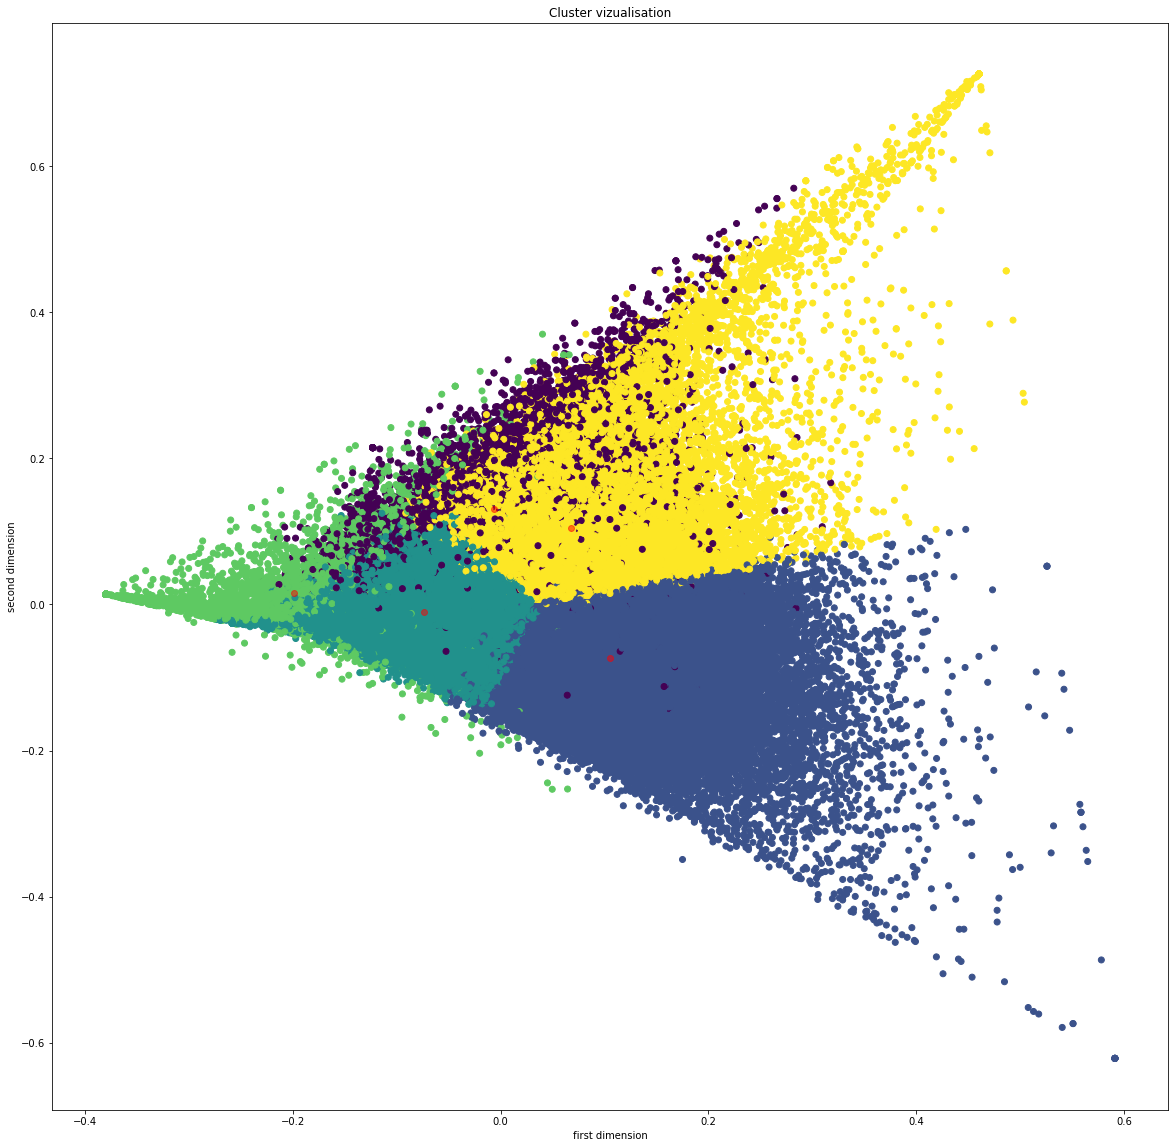

In [76]:
fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(reduc_matrix[:,0], reduc_matrix[:,1], c=kmeans.labels_, cmap='viridis')
centers = kmeans.cluster_centers_
ax.scatter(centers[:,0], centers[:,1], c='red', alpha=0.5)
plt.title('Cluster vizualisation')
plt.xlabel('first dimension')
plt.ylabel('second dimension')

We can see how the clusters were defined. As expected, the small clusters (1 and 2) are not well separated, close to all other centroids. The three other are much well defined, but like before, the separation seems artificially imposed. This is probably due to a difficulty to really differentiate the users, because of the continuum if their habits.

## Constrained clustering

The clusters are not really defined on an healthiness scale, so we will impose it, by clustering considering only the aisles characterizing good or bad comsumption habits. The exact same methods will then be applied (dimensionnality reduction by PCA, an k-means clustering).

**Select the aisles**

We will select only 14 aisles, directly link to the healthiness of the order. 7 of them characterize healthy user, while 7 others characterize unhealthy users.

In [77]:
aisles_health = aisles.loc[[3,12,15,16,23,37,44,49,60,68,76,78,82,122]] #select aisles discriminating on aisles
pd.set_option('display.max_rows', None)
print(aisles_health)
pd.set_option('display.max_rows', 20)

     aisle_id                       aisle
3           4               instant foods
12         13              prepared meals
15         16                 fresh herbs
16         17          baking ingredients
23         24                fresh fruits
37         38                frozen meals
44         45             candy chocolate
49         50      fruit vegetable snacks
60         61               cookies cakes
68         69         soup broth bouillon
76         77                 soft drinks
78         79                frozen pizza
82         83            fresh vegetables
122       123  packaged vegetables fruits


**Create the matrix**

In [78]:
matrix_health = user_matrix[:,aisles_health.aisle_id]

In [79]:
row_sums = matrix_health.sum(axis=1) #Normalize on the rows (rows_sum -> 1)
norm_matrix = matrix_health / row_sums[:, np.newaxis]
for (i, l) in enumerate(norm_matrix) :
    if str(l[0])=="nan":
        for k in range(0, len(norm_matrix[0])):
            norm_matrix[i][k]=0

C:\Users\eloi0\Anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


**Dimensionnality reduction**

In [80]:
pca = PCA(random_state=0) 
pca.fit(norm_matrix)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=0,
    svd_solver='auto', tol=0.0, whiten=False)

In [81]:
reduc_matrix = pca.transform(norm_matrix)

Determine the right number of dimensions as a trade-off between number of dimensions and loss of variance.

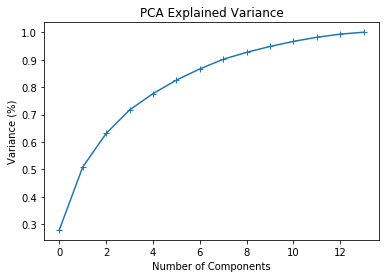

In [82]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='+')
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('PCA Explained Variance')
plt.show()

The dimension is choosen at the elbow : 4.

In [83]:
pca = PCA(n_components=4, random_state=0)
reduc_matrix = pca.fit_transform(norm_matrix)

Let's have a look at the new dimension vectors by looking at the features impacting them the most :

In [84]:
aisle_list = list(aisles_health.aisle)
i=0
for d in pca.components_ :
    print("dimension" + str(i)+" ") 
    i+=1
    if(abs(np.max(d))>abs(np.min(d))):
        print(str(aisle_list[np.argmax(d)]) + " " + str(np.max(d)))
    else :
        print(str(aisle_list[np.argmin(d)])+" "+str(np.min(d)))

dimension0 
fresh fruits 0.8573938597173446
dimension1 
fresh vegetables -0.7682825937213775
dimension2 
packaged vegetables fruits 0.8623142798354194
dimension3 
soft drinks 0.7220041223875744


The aisles defining the independant dimensions arr fruits, vegetables and soft drinks. The three first influencing features are all healthy, only the 4th is unhealthy. The risk is that the cluster won't differentiate between healthy and unhealthy but between other criteria (eat more salty or sweet for instance).

**CLustering**

Determine the right number of clusters (k)

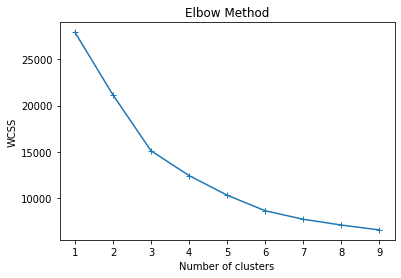

In [85]:
#un peu long
wcss=[]
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(reduc_matrix)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 10), wcss, marker='+')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

The number of clusters k is choosen at the elbow : 3.

In [86]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(reduc_matrix)

In [105]:
mapping = {0:2, 1:1, 2:0}
users_cluster = [mapping[i] for i in kmeans.labels_[1:]]
with open('users_cluster.pk', 'wb') as f:
    pk.dump(users_cluster, f)


## Analysis of the clusters

In [106]:
get_cluster_size(kmeans, 3, reduc_matrix)

93946.0
58321.0
53942.0


The 3 clusters obtained are about the same size.

**Look at centroids distance**

In [107]:
kmeans.cluster_centers_

array([[-0.12931051, -0.14041791, -0.00487076,  0.01175181],
       [ 0.28288385, -0.03182614,  0.01049275,  0.00847705],
       [-0.08040229,  0.27977523, -0.00285237, -0.02970977]])

In [108]:
def dist_centroids(clustering):
    k=len(clustering.cluster_centers_)
    distances = np.zeros((k,k))
    for x in range(k):
        for y in range(x):
            dist = np.linalg.norm(clustering.cluster_centers_[x]-clustering.cluster_centers_[y]) #calculate euclidian distance
            distances[x,y]=dist
    return distances

In [109]:
dist_centroids(kmeans)

array([[0.        , 0.        , 0.        ],
       [0.42654791, 0.        , 0.        ],
       [0.42506167, 0.4803213 , 0.        ]])

The three centroids are well separated from each others.

**convert the matrix into a dataframe**

In [110]:
#convert the matrix into df
matrix_df = pd.DataFrame(matrix_health, index = range(len(matrix_health)), columns = list(aisles_health.aisle) )
matrix_df.head()

,instant foods,prepared meals,fresh herbs,baking ingredients,fresh fruits,frozen meals,candy chocolate,fruit vegetable snacks,cookies cakes,soup broth bouillon,soft drinks,frozen pizza,fresh vegetables,packaged vegetables fruits
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,5,0,1,0,0,0,13,0,0,0
2,0,0,0,2,33,12,0,0,0,0,0,0,0,3
3,4,2,0,0,19,0,0,0,0,0,0,0,5,14
4,0,0,0,0,2,3,0,0,0,1,1,0,0,0


In [111]:
#Add a column 'cluster'
matrix_df['cluster']=kmeans.labels_
matrix_df.head()

,instant foods,prepared meals,fresh herbs,baking ingredients,fresh fruits,frozen meals,candy chocolate,fruit vegetable snacks,cookies cakes,soup broth bouillon,soft drinks,frozen pizza,fresh vegetables,packaged vegetables fruits,cluster
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
1,0,0,0,0,5,0,1,0,0,0,13,0,0,0,2
2,0,0,0,2,33,12,0,0,0,0,0,0,0,3,1
3,4,2,0,0,19,0,0,0,0,0,0,0,5,14,1
4,0,0,0,0,2,3,0,0,0,1,1,0,0,0,2


In [112]:
#Convert Normalized matrix into a df
norm_matrix_df = pd.DataFrame(norm_matrix, index = range(len(norm_matrix)), columns = list(aisles_health.aisle) )
norm_matrix_df.head()

,instant foods,prepared meals,fresh herbs,baking ingredients,fresh fruits,frozen meals,candy chocolate,fruit vegetable snacks,cookies cakes,soup broth bouillon,soft drinks,frozen pizza,fresh vegetables,packaged vegetables fruits
0,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
1,0.000000,0.000000,0.0,0.00,0.263158,0.000000,0.052632,0.0,0.0,0.000000,0.684211,0.0,0.000000,0.000000
2,0.000000,0.000000,0.0,0.04,0.660000,0.240000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.060000
3,0.090909,0.045455,0.0,0.00,0.431818,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.113636,0.318182
4,0.000000,0.000000,0.0,0.00,0.285714,0.428571,0.000000,0.0,0.0,0.142857,0.142857,0.0,0.000000,0.000000


In [113]:
#Add column 'cluster'
norm_matrix_df['cluster']=kmeans.labels_
norm_matrix_df.head()

,instant foods,prepared meals,fresh herbs,baking ingredients,fresh fruits,frozen meals,candy chocolate,fruit vegetable snacks,cookies cakes,soup broth bouillon,soft drinks,frozen pizza,fresh vegetables,packaged vegetables fruits,cluster
0,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,2
1,0.000000,0.000000,0.0,0.00,0.263158,0.000000,0.052632,0.0,0.0,0.000000,0.684211,0.0,0.000000,0.000000,2
2,0.000000,0.000000,0.0,0.04,0.660000,0.240000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.060000,1
3,0.090909,0.045455,0.0,0.00,0.431818,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.113636,0.318182,1
4,0.000000,0.000000,0.0,0.00,0.285714,0.428571,0.000000,0.0,0.0,0.142857,0.142857,0.0,0.000000,0.000000,2


**Study the mean distribution of products per ailse in each clusters**

In [114]:
mean_clusters = norm_matrix_df.groupby(['cluster']).mean()
mean_clusters

,instant foods,prepared meals,fresh herbs,baking ingredients,fresh fruits,frozen meals,candy chocolate,fruit vegetable snacks,cookies cakes,soup broth bouillon,soft drinks,frozen pizza,fresh vegetables,packaged vegetables fruits
cluster,,,,,,,,,,,,,,
0,0.014678,0.006579,0.040838,0.029830,0.233244,0.018336,0.014060,0.008881,0.011333,0.032548,0.014916,0.010743,0.415821,0.148193
1,0.014301,0.007625,0.012892,0.022661,0.540242,0.020444,0.021148,0.016006,0.019068,0.019791,0.023055,0.011094,0.121598,0.150075
2,0.038638,0.014844,0.011300,0.061104,0.099298,0.094962,0.076634,0.030384,0.063426,0.050421,0.153855,0.034891,0.060222,0.123131


**Evaluate the features discrimining the clusters**

In [115]:
matrix_df.corr()['cluster'].sort_values(ascending=True)

fresh vegetables             -0.383537
fresh herbs                  -0.250059
packaged vegetables fruits   -0.199350
fresh fruits                 -0.176672
baking ingredients           -0.087775
soup broth bouillon          -0.080754
prepared meals                0.005062
fruit vegetable snacks        0.017522
instant foods                 0.030767
frozen pizza                  0.051040
candy chocolate               0.080420
cookies cakes                 0.103606
frozen meals                  0.127085
soft drinks                   0.203031
cluster                       1.000000
Name: cluster, dtype: float64

As we will show later, the higher the number of the cluster, the healthier it is. Thus a positive correlation between an aisle and the clusters means it is considerated as an healthy criteria. All our 7 healthy aisles have positive correlation, except fruits snacks. All our 7 unhealthy aisles have negative correlation. This our labellization of the clusters, and that that they can be distinguished in an healthiness scale. 

In [116]:
array = norm_matrix_df.values
X = array[:,0:-1]
Y = array[:,-1]

In [117]:
scores = SelectKBest(chi2, k='all').fit(X, Y)

In [118]:
features = pd.DataFrame(index=norm_matrix_df.columns[:-1], data= scores.scores_, columns=["Score"]).sort_values("Score",ascending=False)
features.head(14)

,Score
fresh vegetables,22810.973717
fresh fruits,20739.573097
soft drinks,13762.840061
frozen meals,5878.569839
candy chocolate,4456.212870
cookies cakes,3620.807495
fresh herbs,1675.355401
frozen pizza,1338.870290
baking ingredients,1332.573760
instant foods,1110.824150


As expected, consumption of fresh fruits and vegetables are really meaningfull. Then the comsumption of oft drinks and frozen meals characterize the unhealthy users.

In [119]:
mean_clusters[features.index]

,fresh vegetables,fresh fruits,soft drinks,frozen meals,candy chocolate,cookies cakes,fresh herbs,frozen pizza,baking ingredients,instant foods,fruit vegetable snacks,soup broth bouillon,prepared meals,packaged vegetables fruits
cluster,,,,,,,,,,,,,,
0,0.415821,0.233244,0.014916,0.018336,0.014060,0.011333,0.040838,0.010743,0.029830,0.014678,0.008881,0.032548,0.006579,0.148193
1,0.121598,0.540242,0.023055,0.020444,0.021148,0.019068,0.012892,0.011094,0.022661,0.014301,0.016006,0.019791,0.007625,0.150075
2,0.060222,0.099298,0.153855,0.094962,0.076634,0.063426,0.011300,0.034891,0.061104,0.038638,0.030384,0.050421,0.014844,0.123131


The healthiest cluster is the cluster 2 (many vegetables), then the cluster 1 (many fruits) and the cluster 0 is unhealthy (soft drinks, frozen meals, candys...)

**Vizualisation**

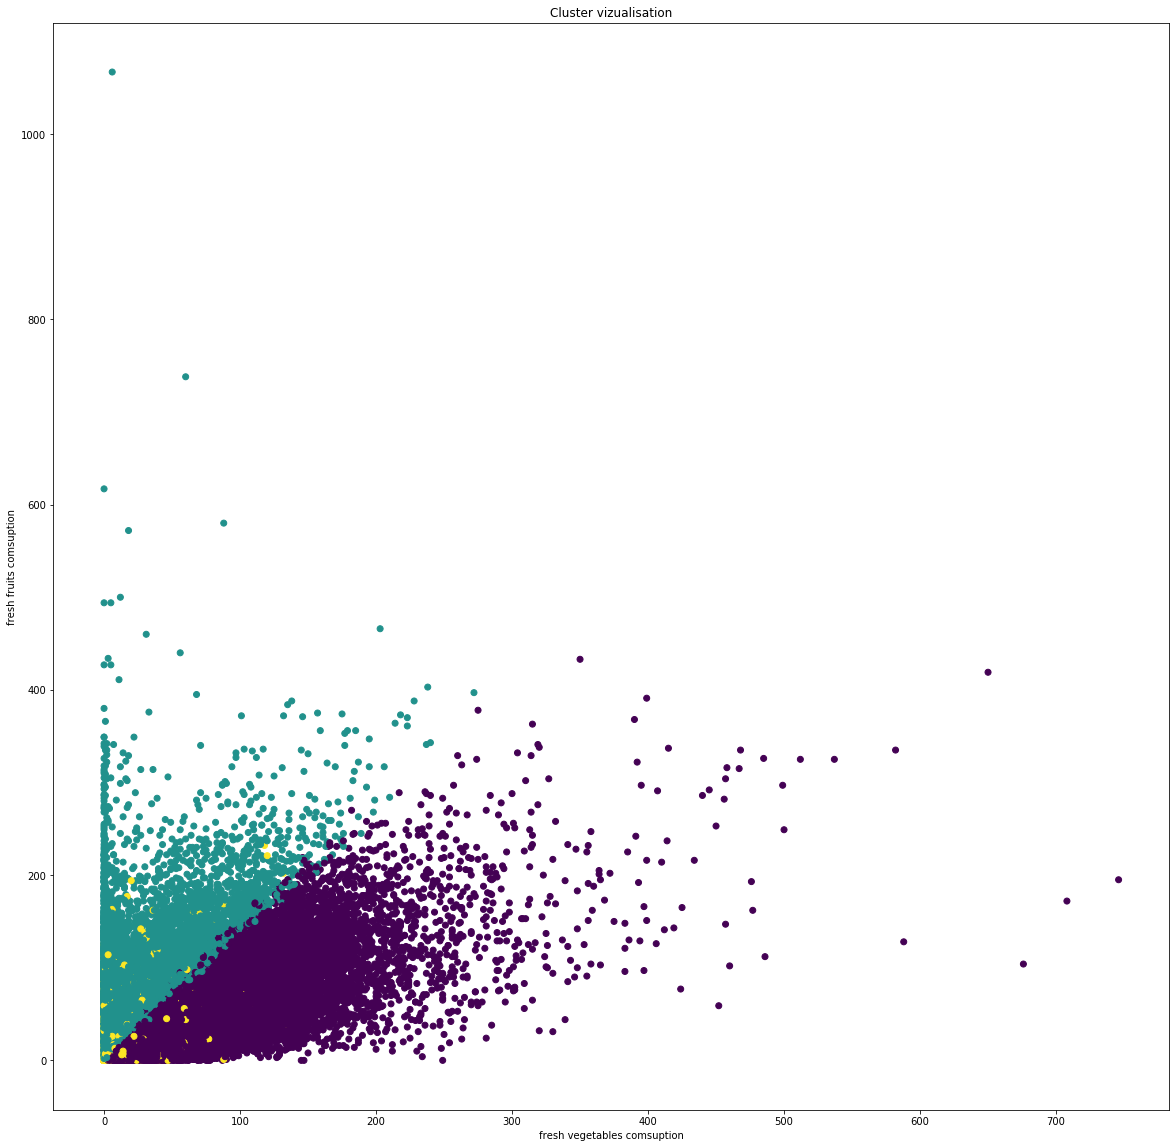

In [120]:
fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(matrix_df['fresh vegetables'], matrix_df['fresh fruits'], c=matrix_df['cluster'], cmap='viridis')
plt.title('Cluster vizualisation')
plt.xlabel('fresh vegetables comsuption')
plt.ylabel('fresh fruits comsuption')
plt.show()

We can see that in this dimensions (the aisles with high weigh on 2 first PCA dimensions), 2 clusters are well defined (the 1 and 2). But the separation seems artifically imposed. Actually this means the two healthy users group is separating people eating more vegetables or fruits.

Text(0, 0.5, 'soft drinks comsuption')

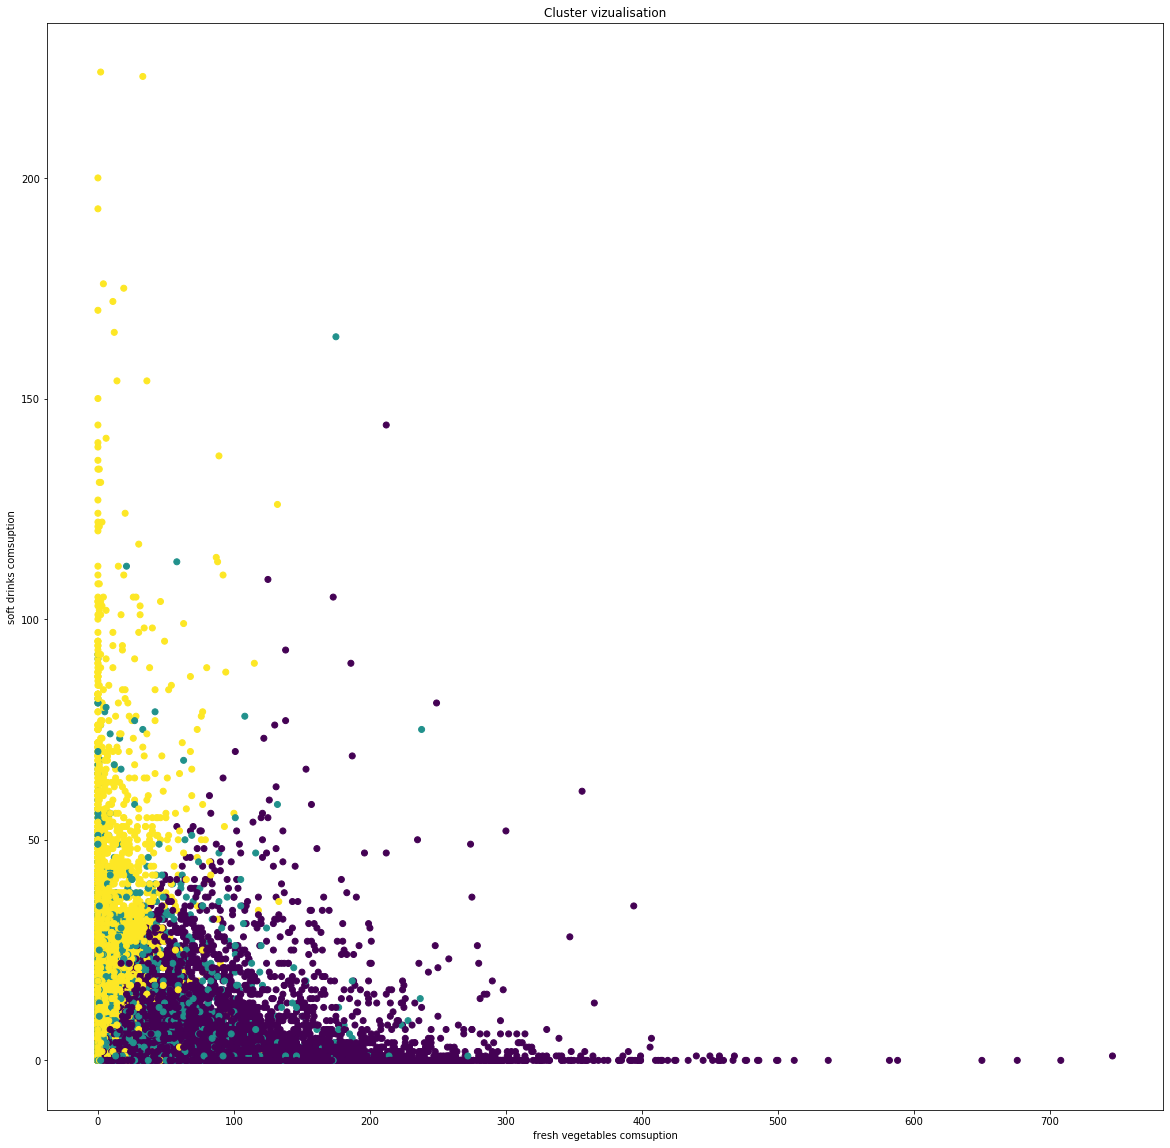

In [121]:
fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(matrix_df['fresh vegetables'], matrix_df['soft drinks'], c=matrix_df['cluster'], cmap='viridis')
plt.title('Cluster vizualisation')
plt.xlabel('fresh vegetables comsuption')
plt.ylabel('soft drinks comsuption')

When including an unhealthy aisle in the scale : Clusters are not well separated.

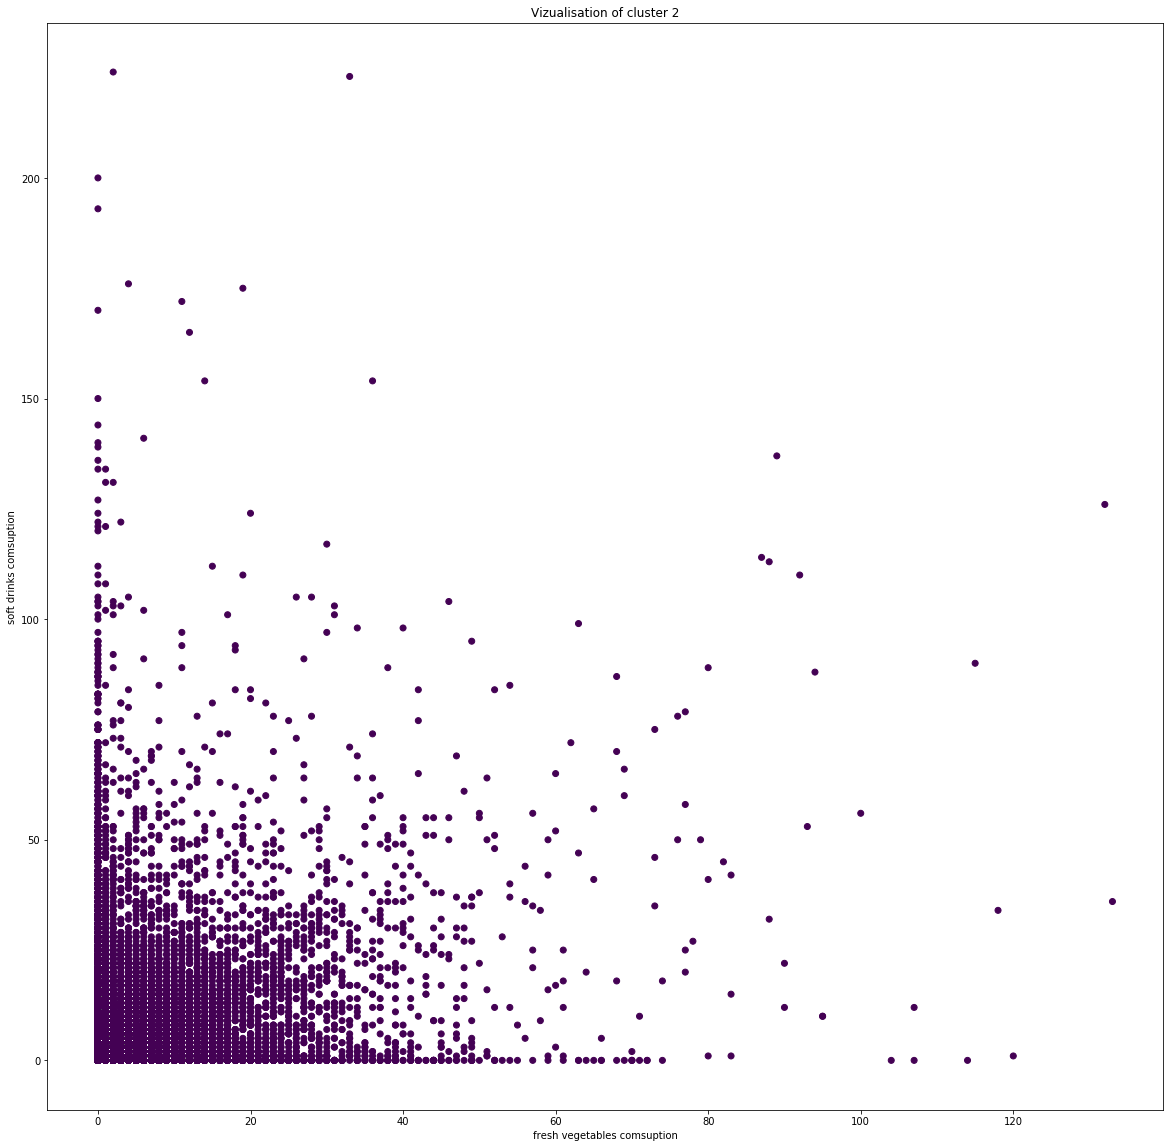

In [122]:
fig, ax = plt.subplots(figsize=(20,20))
dessin = matrix_df[matrix_df.cluster ==2 ]
ax.scatter(dessin['fresh vegetables'], dessin['soft drinks'], c=dessin['cluster'], cmap='viridis')
plt.title('Vizualisation of cluster 2')
plt.xlabel('fresh vegetables comsuption')
plt.ylabel('soft drinks comsuption')
plt.show()

We can just see that healthy users (cluster 2) do not drink lots of soft drinks, almost at all

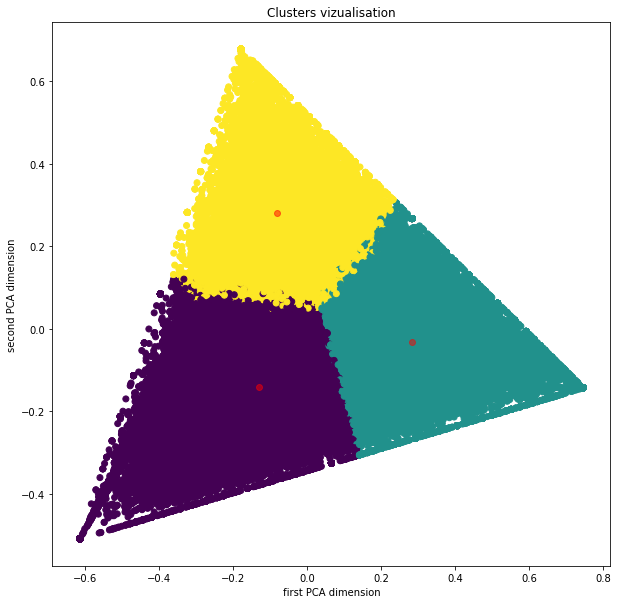

In [123]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(reduc_matrix[:,0], reduc_matrix[:,1], c=kmeans.labels_, cmap='viridis')
centers = kmeans.cluster_centers_
ax.scatter(centers[:,0], centers[:,1], c='red', alpha=0.5)
plt.title('Clusters vizualisation')
plt.xlabel('first PCA dimension')
plt.ylabel('second PCA dimension')
plt.show()

Representation in the first two dimensions of the PCA : we can see how the clusters were defined. The three clusters are much well defined, but like before, the separation seems artificially imposed. This is probably due to a difficulty to really differentiate the users, because of the continuum if their habits.

## Habits

In [124]:
def stats_cluster(nb_cluster):
    user = matrix_df.index[matrix_df.cluster==nb_cluster]

    # Timing of orders
    print (orders[orders.user_id.isin(user)].groupby('order_id').mean().describe())

In [125]:
stats_cluster(0)

            user_id  order_number     order_dow  order_hour_of_day  \
count  1.614624e+06  1.614624e+06  1.614624e+06       1.614624e+06   
mean   1.025769e+05  1.749949e+01  2.743390e+00       1.360826e+01   
std    5.954573e+04  1.791411e+01  2.107364e+00       4.241911e+00   
min    5.000000e+00  1.000000e+00  0.000000e+00       0.000000e+00   
25%    5.112100e+04  5.000000e+00  1.000000e+00       1.100000e+01   
50%    1.021030e+05  1.100000e+01  3.000000e+00       1.400000e+01   
75%    1.538800e+05  2.400000e+01  5.000000e+00       1.700000e+01   
max    2.062080e+05  1.000000e+02  6.000000e+00       2.300000e+01   

       days_since_prior_order  
count            1.520678e+06  
mean             1.092950e+01  
std              9.128876e+00  
min              0.000000e+00  
25%              4.000000e+00  
50%              7.000000e+00  
75%              1.500000e+01  
max              3.000000e+01  


In [126]:
stats_cluster(1)

            user_id  order_number     order_dow  order_hour_of_day  \
count  1.048222e+06  1.048222e+06  1.048222e+06       1.048222e+06   
mean   1.036200e+05  1.852824e+01  2.748179e+00       1.326560e+01   
std    5.954066e+04  1.857796e+01  1.996107e+00       4.252748e+00   
min    2.000000e+00  1.000000e+00  0.000000e+00       0.000000e+00   
25%    5.181500e+04  5.000000e+00  1.000000e+00       1.000000e+01   
50%    1.035070e+05  1.200000e+01  3.000000e+00       1.300000e+01   
75%    1.554120e+05  2.600000e+01  5.000000e+00       1.600000e+01   
max    2.062090e+05  1.000000e+02  6.000000e+00       2.300000e+01   

       days_since_prior_order  
count           989901.000000  
mean                10.535686  
std                  8.909557  
min                  0.000000  
25%                  4.000000  
50%                  7.000000  
75%                 14.000000  
max                 30.000000  


In [127]:
stats_cluster(2)

             user_id   order_number      order_dow  order_hour_of_day  \
count  758237.000000  758237.000000  758237.000000      758237.000000   
mean   102945.639780      14.522342       2.884891          13.376996   
std     59490.919543      15.764916       1.980485           4.142030   
min         1.000000       1.000000       0.000000           0.000000   
25%     51462.000000       4.000000       1.000000          10.000000   
50%    102809.000000       9.000000       3.000000          13.000000   
75%    154219.000000      19.000000       5.000000          16.000000   
max    206206.000000     100.000000       6.000000          23.000000   

       days_since_prior_order  
count           704295.000000  
mean                12.329003  
std                  9.664052  
min                  0.000000  
25%                  5.000000  
50%                  9.000000  
75%                 19.000000  
max                 30.000000  


In [128]:
def orders_qte(nb_cluster):
    user = matrix_df.index[matrix_df.cluster==nb_cluster]
    order_cluster = orders[orders.user_id.isin(user)].order_id
    print(history[history.order_id.isin(order_cluster)].groupby('order_id').count().mean())

In [129]:
orders_qte(0)

product_id           11.279033
add_to_cart_order    11.279033
reordered            11.279033
dtype: float64


In [130]:
orders_qte(1)

product_id           9.399271
add_to_cart_order    9.399271
reordered            9.399271
dtype: float64


In [131]:
orders_qte(2)

product_id           8.488437
add_to_cart_order    8.488437
reordered            8.488437
dtype: float64


There is no differences of users's habits between the clusters (days and hour of orders, days after the last order, number of orders). Thus, there is no advice to give to the less healthy group regarding their habits.

# IV - Giving scores to products

The very first idea coming to mind when one wants to improve people's consumption habits is to make them consume healthy products. The problem of this approach is the requirement of a "healthiness score" that is not easy to evaluate.
A second approach would be to advise products that consumers usually like. Again, this will bring us to define an "appreciation score" reflecting how likely a consumer is to re-buy this product.


## I - Healthiness score

No information concerning the products' healthiness is provided in the datasets. By clustering the users according to their consumptions in each aisle, we can separate them into more or less healthy groups. Now, we define the healthiness of a production as a function of the distribution of people who consumed this product.
For instance, if a "healthy" user consumes a certain product, it gives 4 points to this product. An "average" consumer would give 1 point, while an "unhealthy" consumer would remove 1 point to the product. Then, it is easy to adapt this (arbitrary) scores making a weighted average taking the number of consumptions into account. The bigger the score, the healthier the product.
In particular, if a product has a score of -1, it means that it's only consumed by people of the unhealthy cluster, and a product rated 4 is only conumed by people of the healthy cluster.
The healthiness score may be irrelevant when a product is only consumed by very few people, because it introduces a great variance in score evaluation.

## II - Appreciation score

We can decude from our dataset the average number of times a product is re-bought. Nevertheless, we have to take the consumer's consumption habits into account. For instance, imagine a consumer, Ada, buying everytime the same set of products, and bought each of them 10 times, except one product, let's say "chicory and ham", which wasn't so good, and she bought it only 4 times. Now imagine  a second consumer Robert, who doesn't like consuming the same products, and tries to have a very varied consumption. He bought once each product, except one, say "goat cheese", which he loved and bought 3 times. If Ada and Robert are the only consumers of the dataset, "chicory and ham" would have a better appreciation score (that is 4) than "goat cheese" (score of 3). We don't want this to happen ! 
This is why we normalize the contribution of each user by the average time he or she consumes each product. Then, we avarege the scores obtained for each user, and obtain a general appreciation score for the product. The greater, the more the product is likely to be re-bought. The score itself is difficult to  interpret, but we can compare different scores quite safely.

## III - Limitations

Some products have been consumed by very few people, sometimes 0, so we have no (reliable) information about their scores. A quick exploration of these products show that they are not products we would want to advise, because they are too specific. As an example, we can mention and . Our decision for these products is to give them a score of 0.

## 1 - Client fidelity and ranking of products - basic statistics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [11]:
consumptions = pd.merge(history, orders, on="order_id")
consumptions = consumptions[["order_id","user_id","add_to_cart_order","reordered","order_number","product_id"]]
consumptions["count"]=1
consumptions.head()

,order_id,user_id,add_to_cart_order,reordered,order_number,product_id,count
0,2,202279,1,1,3,33120,1
1,2,202279,2,1,3,28985,1
2,2,202279,3,0,3,9327,1
3,2,202279,4,1,3,45918,1
4,2,202279,5,0,3,30035,1


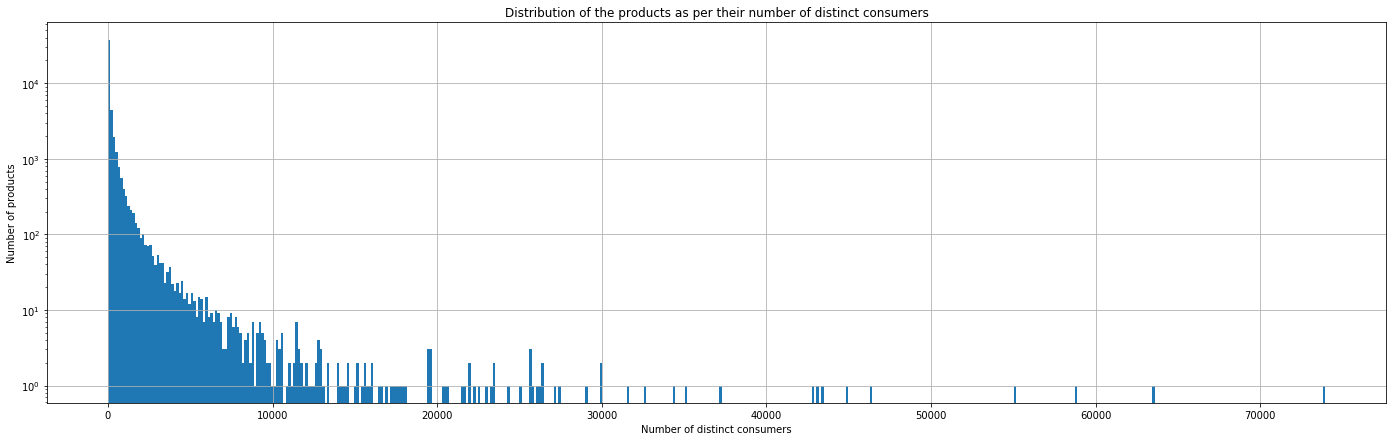

In [12]:
# Plot the distribution of products according to their number of consumers
distinct_users = consumptions.groupby(["product_id","user_id"]).agg({"count":"mean"})
nb_consumers = distinct_users.groupby("product_id").agg({"count":'sum'})
fig, ax = plt.subplots(figsize=(24,7))
nb_consumers.hist(ax=ax, bins=500)
ax.set_yscale('log')
ax.set_xlabel("Number of distinct consumers")
ax.set_ylabel("Number of products")
ax.set_title("Distribution of the products as per their number of distinct consumers")
plt.savefig("Distribution_of_products.png")
plt.show()

### 2 - Fidelity of the users

In [13]:
def get_user_fidelity(consumptions) :
    fidelity = consumptions.groupby(["user_id","product_id"]).agg({'reordered': "sum"})
    fidelity_per_user = fidelity.groupby("user_id").agg({'reordered':'mean'})
    fidelity_per_user.columns=["user_fidelity"]
    return fidelity_per_user

def reliable_user_fidelity(consumptions, min_consumptions = 3):
    nb_orders = consumptions.groupby(["user_id"]).agg({"order_number":"max"})
    fidelity_per_user = get_user_fidelity(consumptions)
    fidelity_and_reliability =pd.merge(fidelity_per_user,nb_orders, on = "user_id")
    return fidelity_and_reliability[fidelity_and_reliability.order_number >= min_consumptions]

If certain users only ordered once, it doesn't make sense to estimate their fidelity to a product. So we filter them by selecting only the ones who ordered at least a certain number of times.

In [14]:
min_consumptions = 3
usr_fid = reliable_user_fidelity(consumptions, min_consumptions).sort_values(by='user_fidelity')
nb_reliable_users =len(usr_fid)
nb_users = max(consumptions.user_id)
print(round(nb_reliable_users*100/nb_users,2),"% of the users consumed more at least three times.")
usr_fid.head()

100.0 % of the users consumed more at least three times.


,user_fidelity,order_number
user_id,,
172715,0.0,3
120758,0.0,4
21696,0.0,3
126466,0.0,3
66649,0.0,3


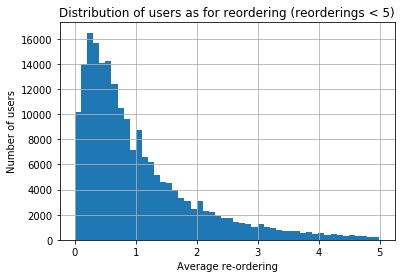

In [15]:
usr_fid[["user_fidelity"]][usr_fid<5].hist(bins=50)
ax = plt.gca()
ax.set_xlabel("Average re-ordering")
ax.set_ylabel("Number of users")
ax.set_title("Distribution of users as for reordering (reorderings < 5)")
plt.show()

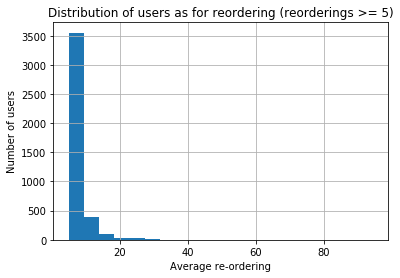

In [16]:
usr_fid[["user_fidelity"]][usr_fid>=5].hist(bins=20)
ax = plt.gca()
ax.set_xlabel("Average re-ordering")
ax.set_ylabel("Number of users")
ax.set_title("Distribution of users as for reordering (reorderings >= 5)")
plt.show()

Most users consume on average a product less than once. We observe big peaks at 0, 1/2, 1 and 2, which must correspond to users who consumed rarely.

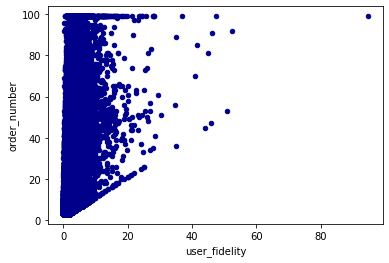

In [17]:
ax1 = usr_fid.plot.scatter(x='user_fidelity', y='order_number',c='DarkBlue')

Surprisingly enough, consumers who reorder the most on average are among the greatest consumers.

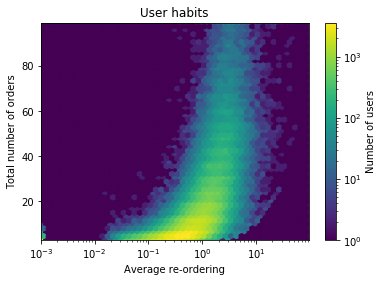

In [18]:
def plot_usr_fid(usr_fid):
    x = np.array(usr_fid.user_fidelity)+0.001
    y= np.array(usr_fid.order_number)
    ax = plt.gca()
    hb = ax.hexbin(x, y, gridsize=50, bins='log', xscale='log')
    ax.set(xlim=(0.001, max(x)), ylim=(min_consumptions, max(y)))
    ax.set_title("User habits")
    ax.set_xlabel("Average re-ordering")
    ax.set_ylabel("Total number of orders")
    cb = plt.colorbar(hb, ax=ax)
    cb.set_label('Number of users')    
    plt.show()
    
plot_usr_fid(usr_fid)

Most users only ordered a few times, and small 
Above a certain number of orders, the average re-ordering can't be too low, which can be explained by the fact that people who buy so much either already have tried all the products, or (more likely) have strong consumption habits.

### 3 - Product "fidelity score"

Now, for one given product, we would like to know if users appreciate it in general, that is their average fidelity to this given product. But this should be normalized by the average fidelity of each user ! If a product has been consumed only by 1 particular user who bought it thrice but usually buys  products 10 times, we don't want it to get a great score.

In [19]:
def get_addictivities(consumptions):
    consumptions["prod_id"]=consumptions["product_id"]
    fidelity = consumptions.groupby(["user_id","prod_id"]).agg({'reordered': "sum","product_id":"mean"})
    fidelity_per_user = get_user_fidelity(fidelity)    
    # Get fidelity table together with average user fidelity
    with_user_fidelity = pd.merge(fidelity, fidelity_per_user[fidelity_per_user.user_fidelity>0], on="user_id")
    # Normalize fidelity to one product by user fidelity
    with_user_fidelity["appreciation_per_user"] = with_user_fidelity.reordered/with_user_fidelity.user_fidelity
    return with_user_fidelity.groupby("product_id").agg({"appreciation_per_user":"mean"})

fidelity_scores = get_addictivities(consumptions)
fidelity_scores.sort_values("appreciation_per_user").tail()

,appreciation_per_user
product_id,
1470,8.800000
34246,9.382511
15201,9.886176
2075,10.741471
25135,11.634876


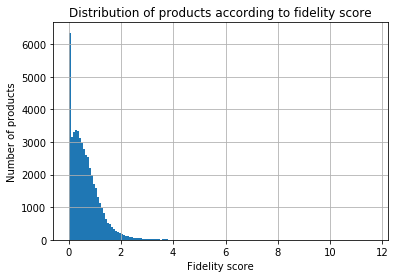

In [20]:
fidelity_scores.hist(bins=150)
ax = plt.gca()
ax.set_xlabel("Fidelity score")
ax.set_ylabel("Number of products")
ax.set_title("Distribution of products according to fidelity score")
plt.show()

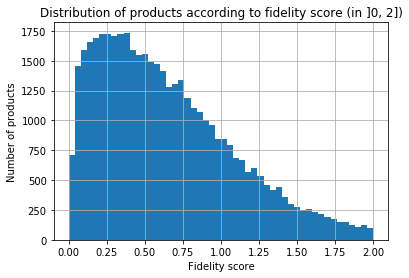

In [21]:
fidelity_scores_less5 = fidelity_scores[fidelity_scores.appreciation_per_user<2]
fidelity_scores_less5[0<fidelity_scores_less5.appreciation_per_user].hist(bins=50)
ax = plt.gca()
ax.set_xlabel("Fidelity score")
ax.set_ylabel("Number of products")
ax.set_title("Distribution of products according to fidelity score (in ]0, 2])")
plt.show()

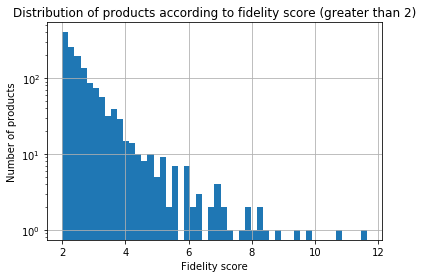

In [22]:
fidelity_scores_more5 = fidelity_scores[fidelity_scores.appreciation_per_user>=2]
fidelity_scores_more5.hist(bins=50, log=True)
ax = plt.gca()
ax.set_xlabel("Fidelity score")
ax.set_ylabel("Number of products")
ax.set_title("Distribution of products according to fidelity score (greater than 2)")
plt.show()

Let's confront those values to the reliability of each score, that corresponds to the number of times the product was bought.

In [23]:
# Add the weight of each product
product_weights = consumptions.groupby("product_id").agg({"count":"sum"})
fidelity_scores_weights = pd.merge(product_weights, fidelity_scores, on= "product_id")
fidelity_scores_weights.head()

,count,appreciation_per_user
product_id,,
1,1852,0.624966
2,90,0.103647
3,277,1.746200
4,329,0.963089
5,15,1.455579


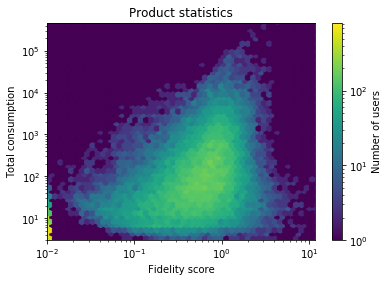

In [24]:
def plot_scores_weights(fidelity_scores):
    x = np.array(fidelity_scores.appreciation_per_user)+0.01
    y = np.array(fidelity_scores["count"])
    ax = plt.gca()
    hb = ax.hexbin(x, y, gridsize=50, bins='log', xscale='log', yscale='log')
    ax.set(xlim=(0.01, max(x)), ylim=(min_consumptions, max(y)))
    ax.set_title("Product statistics")
    ax.set_xlabel("Fidelity score")
    ax.set_ylabel("Total consumption")
    cb = plt.colorbar(hb, ax=ax)
    cb.set_label('Number of users')    
    plt.show()
    
plot_scores_weights(fidelity_scores_weights)

We can't see a very clear correlation. Nevertheless, we can remark 2 things.

1 - Most consumed products overall are on average better-liked than others (score greater than 1).

2 - A great number of products was only bought once by a less than a dozen of users.

### 4 - Average score per aisle

We might think about averaging the scores of products present in each aisle, but some of them may be undefined, and some products might be much more consumed than others. Again we have to put some weights.

In [25]:
def get_aisle_scores(fidelity_scores_weights, products, aisles):
    scores_with_aisles = pd.merge(fidelity_scores_weights, products, on ="product_id")
    scores_with_aisles["total_appreciation"]= scores_with_aisles.appreciation_per_user * scores_with_aisles["count"]
    aisle_scores = scores_with_aisles.groupby("aisle_id").agg({"total_appreciation":"sum","count":"sum"})
    aisle_scores["average_appreciation"] = aisle_scores.total_appreciation / aisle_scores["count"]
    aisle_scores_labelled = pd.merge(aisles, aisle_scores, on="aisle_id")
    return aisle_scores_labelled

aisle_scores_labelled = get_aisle_scores(fidelity_scores_weights, products, aisles)
aisle_scores_labelled.sort_values(by="average_appreciation", ascending=False).head(20)

,aisle_id,aisle,total_appreciation,count,average_appreciation
83,84,milk,2.380470e+06,891015,2.671639
23,24,fresh fruits,7.497222e+06,3642188,2.058439
114,115,water seltzer sparkling water,1.725478e+06,841533,2.050399
85,86,eggs,8.806596e+05,452134,1.947785
61,62,white wines,5.810277e+04,30558,1.901393
90,91,soy lactosefree,1.127046e+06,638253,1.765830
52,53,cream,5.369541e+05,318002,1.688524
123,124,spirits,4.545201e+04,28102,1.617394
76,77,soft drinks,5.550284e+05,357537,1.552366
111,112,bread,8.971647e+05,584834,1.534050


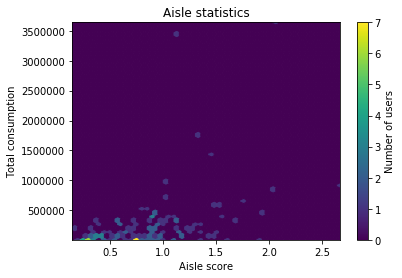

In [26]:
def plot_aisle_scores(aisle_scores):
    x = np.array(aisle_scores.average_appreciation)
    y = np.array(aisle_scores["count"])
    ax = plt.gca()
    hb = ax.hexbin(x, y, gridsize=50)#, xscale='log', yscale='log')
    ax.set(xlim=(min(x), max(x)), ylim=(min(y), max(y)))
    ax.set_title("Aisle statistics")
    ax.set_xlabel("Aisle score")
    ax.set_ylabel("Total consumption")
    cb = plt.colorbar(hb, ax=ax)
    cb.set_label('Number of users')    
    plt.show()
    
plot_aisle_scores(aisle_scores_labelled)

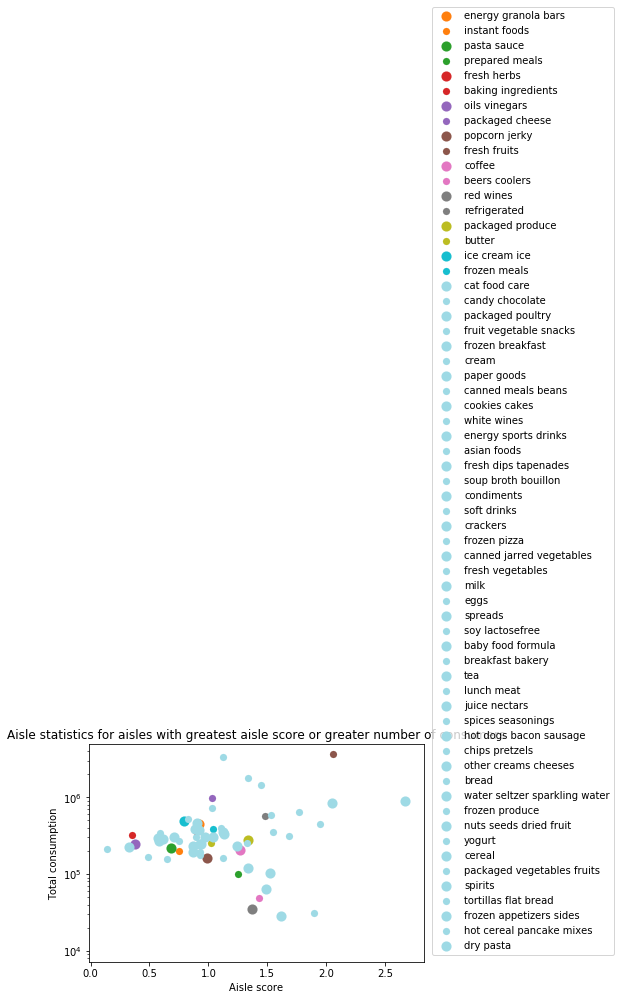

In [27]:
from matplotlib.cm import tab20
from matplotlib.colors import rgb2hex 

# create a scatterplot function
def scatter_plot(df,x_axis, y_axis, l_axis, x_legend, y_legend, title, y_log_scale = False) :
    '''Plots the variables x_axis, y_axis stored in columns of the dataframe df. The legend is from the column l_axis of the datframe. The other parameters have obvious names.'''
    fig, ax = plt.subplots()
    nb=0
    for i in range(df.shape[0]):
        x = df[x_axis][i]
        y = float(df[y_axis][i])
        l = df[l_axis][i]
        if x>1.25 or y>150000 :
            nb+=1
            # We use a categorical colormap to identify clearly the different subreddits
            ax.scatter(x, y, label=l, s=50*(1+nb%2), linewidth=0.1, c=rgb2hex(tab20(round(nb+1/2))))
    ax.legend(loc="lower left", bbox_to_anchor= (1.01, 0.01), ncol=1)
    if y_log_scale : ax.set_yscale('log')
    plt.xlabel(x_legend)
    plt.ylabel(y_legend)
    plt.title(title)
    plt.show()
    
scatter_plot(aisle_scores_labelled,"average_appreciation","count","aisle","Aisle score","Total consumption", "Aisle statistics for aisles with greatest aisle score or greater number of consumers",True)

### 5 - Healthiness comes in the game

In [29]:
f = open("users_cluster.pk","rb")
users_cluster = pickle.load(f)
f.close()
dict_cluster = {}
for (user, cluster) in enumerate(users_cluster):
    dict_cluster[user+1] = cluster   # users_cluster[i] = cluster of user whose id is i+1
users = pd.DataFrame.from_dict(dict_cluster, orient='index')
users.columns=["cluster_id"]
users["user_id"] = users.index

In [30]:
consumption_clusters = pd.merge(consumptions[["order_id","product_id","user_id","count"]], users, on="user_id")
per_product = consumption_clusters.groupby(["product_id","user_id"]).agg({"count":"sum","cluster_id":"mean"})

In [33]:
def cluster_to_coeff(cluster_id):
    return -0.5*(cluster_id-1)*(cluster_id-2)-cluster_id*(cluster_id-2) + 2*cluster_id*(cluster_id-1)
# Maps 0 to -1, 1 to 1 and 2 to 4
per_product["healthiness_score"] = cluster_to_coeff(per_product.cluster_id)
per_product["total_healthiness_score"] = per_product.healthiness_score * per_product["count"]
healthiness_per_product = per_product.groupby("product_id").agg({"count":"sum","total_healthiness_score":"sum"})
healthiness_per_product["average_healthiness"] = healthiness_per_product.total_healthiness_score / healthiness_per_product["count"]

In [34]:
healthiness_per_product[["average_healthiness"]].head()

,average_healthiness
product_id,
1,-0.007019
2,2.888889
3,1.350181
4,-0.115502
5,4.000000


In [35]:
final_data_products = pd.merge(healthiness_per_product[["average_healthiness"]],fidelity_scores_weights, on="product_id")
final_data_products.to_pickle("product_scores")
final_data_products.head(20)

,average_healthiness,count,appreciation_per_user
product_id,,,
1,-0.007019,1852,0.624966
2,2.888889,90,0.103647
3,1.350181,277,1.746200
4,-0.115502,329,0.963089
5,4.000000,15,1.455579
6,1.500000,8,0.357683
7,1.500000,30,0.553231
8,0.684848,165,1.153505
9,1.461538,156,0.970810


### See whether the healthiness measure makes sense

Compute average healthiness per aisle:

In [ ]:
healthiness_per_aisle = {}
for aisle in food_aisles:
    healthiness_per_aisle[aisle] = pd.merge(by_aisle[aisle], product_scores, left_on='product_id', right_on='product_id')

In [ ]:
for aisle in food_aisles:
    print(aisle, healthiness_per_aisle[aisle].mean()['healthiness'])
    print("====================")

See what proportion of products of each aisle are considered "target" products:

In [ ]:
for aisle in food_aisles:
    t = 0
    g = 0
    lst = []
    for ind in by_aisle[aisle]['product_id']:
        if ind in product_scores.index:
            lst.append(product_scores.at[ind, 'healthiness'])
        if ind in product_scores.index and product_scores.at[ind, 'healthiness']>=2:
            g += 1
        t+=1
    print(aisle, float(g)/t, g, t)

The healthiness measure that we have devised seems rather consistent and accurate, as the aisles with healthy-sounding names have globally better healthiness scores and a higher proportion of "target" products.

# V - Graph and recommendations

Now, we want to recommend "healthier" products to users whom we consider as having a rather unhealthy consumption habits. To do this, we make for each aisle a graph of products where two products that are bought by the same users are connected by an edge of low weight: the lower the weight, the more users buy both products (and the more they buy each product). Then, we hope that two products that are connected by a low-weight edge are appreciated by the same users and share some characteristis. Thus it should make sense to recommend, instead of a product deemed "unhealthy", a product of the same aisle and with a very short path from the "unhealthy" product.

Let's build this graph of products and use it to make some recommendations.

Make a dataframe containing the orders with the details of the products

In [ ]:
orders_products = pd.merge(orders, history, on='order_id').drop(['add_to_cart_order', 'reordered'], axis=1)

In [14]:
orders_products.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id
0,473747,1,prior,3,3,12,21.0,196
1,473747,1,prior,3,3,12,21.0,12427
2,473747,1,prior,3,3,12,21.0,10258
3,473747,1,prior,3,3,12,21.0,25133
4,473747,1,prior,3,3,12,21.0,30450


Save and/or load the dataframe

In [12]:
orders_products.to_pickle('orders_products.pk')

In [13]:
orders_products = pd.read_pickle('orders_products.pk')

Now, we need to select only food-related products.

Because dataframes containing all the products and orders are really big to handle, we separate products by aisle and store each aisle's dataframe separately.

In [15]:
food_depts = ['bulk', 'meat seafood', 'snacks', 'beverages', 'frozen', 'dairy eggs', 'canned goods', 'dry goods pasta', 'produce', 'bakery', 'deli', 'breakfast', 'alcohol', 'pantry', 'international']

In [21]:
food_aisles = {row.aisle for i, row in products_litteral.iterrows() if row.department in food_depts}

Save and/or load the dataframe

In [17]:
with open('food_aisles.pk', 'wb') as file:
    pk.dump(food_aisles, file)

In [39]:
with open('food_aisles.pk', 'rb') as file:
    food_aisles = pk.load(file)

For each aisle, make the dataframe containing all its products' information (and save/load)

In [23]:
by_aisle = {}
for aisle in food_aisles:
    by_aisle[aisle] = products_litteral[products_litteral.aisle==aisle]
    by_aisle[aisle].to_pickle('by_aisle_'+aisle+'.pk')

In [24]:
by_aisle = {}
for aisle in food_aisles:
    by_aisle[aisle] = pd.read_pickle('by_aisle_'+aisle+'.pk')

In [25]:
# this is needed otherwise the kernel will end up dying because it is overloaded
del(products_litteral)

For each aisle, make the dataframe containing all orders (and save/load).

In [31]:
orders_products_by_aisle = {}
for aisle in food_aisles:
    orders_products_by_aisle[aisle] = pd.merge(orders_products, by_aisle[aisle], on='product_id')[['user_id', 'product_id', 'order_id', 'product_name']]

Now count the number of orders of each product for each user (and save/load).

In [32]:
orders_users_by_aisle = {}
for aisle in food_aisles:
    orders_users_by_aisle[aisle] = orders_products_by_aisle[aisle].groupby(['user_id', 'product_id', 'product_name']).count().rename(columns={'order_id':'nb_orders'})
    orders_users_by_aisle[aisle].to_pickle('orders_users_by_aisle_'+aisle+'.pk')

In [33]:
orders_users_by_aisle = {}
for aisle in food_aisles:
    orders_users_by_aisle[aisle] = pd.read_pickle('orders_users_by_aisle_'+aisle+'.pk')
    print(orders_users_by_aisle[aisle].head())

                                                          nb_orders
user_id product_id product_name                                    
2       22963      Organic Roasted Turkey Breast                  1
        27344      Uncured Genoa Salami                           1
        36735      Organic Roasted Sliced Chicken Breast          2
5       27344      Uncured Genoa Salami                           1
7       19019      Uncured Slow Cooked Ham                        1
                                                              nb_orders
user_id product_id product_name                                        
12      12206      Basil Pesto                                        1
19      34887      Chunky Tomato Garlic & Onion Pasta Sauce           1
        47193      Roasted Garlic Alfredo Pasta Sauce                 1
35      210        Homemade Hot Arrabbiata Fra Diavolo Sauce          1
        39619      Organic Tomato Basil Pasta Sauce                   1
                    

                                           nb_orders
user_id product_id product_name                     
1       10326      Organic Fuji Apples             1
        13176      Bag of Organic Bananas          1
        17122      Honeycrisp Apples               1
        41787      Bartlett Pears                  1
2       16797      Strawberries                    1
                                               nb_orders
user_id product_id product_name                         
65      5161       Dried Mango                         3
138     1000       Apricots                            1
140     1000       Apricots                            2
186     22827      Organic Black Mission Figs          1
204     1000       Apricots                            1
                                                                       nb_orders
user_id product_id product_name                                                 
1       196        Soda                                             

                                          nb_orders
user_id product_id product_name                    
8       39110      Red Chili Flakes               1
9       481        Black Peppercorns              1
10      7746       Oregano                        1
        8988       Organic Garlic Powder          1
        13212      Ground Black Pepper            1
                                                                 nb_orders
user_id product_id product_name                                           
10      16857      Barcelona Vinaigrette Mediterranean Style             1
12      39667      Natural Shiitake Sesame Vinaigrette Dressing          1
19      21001      Creamy French Dressing Salad                          1
        22608      Fat Free Italian Salad Dressing                       1
        30123      Ranch Salad Dressing                                  1
                                                                nb_orders
user_id product_id product_name      

                                                                       nb_orders
user_id product_id product_name                                                 
5       43693      Whole Vitamin D Milk                                        1
11      35321      Organic Lowfat Milk                                         1
12      48835      Organic Unsweetened Vanilla Coconut Non-Dairy B...          1
13      4210       Whole Milk                                                  3
22      27845      Organic Whole Milk                                          2
                                                             nb_orders
user_id product_id product_name                                       
6       38293      Ground Turkey Breast                              1
10      38293      Ground Turkey Breast                              1
32      21927      Organic Boneless Skinless Chicken Breast          2
54      22713      Ground Chicken Breast                             1
       

We want to normalize the number of orders (_i.e._ divide by the total number of food buys for each user) because we are omre interested in the preference of users for some products (relatively to other products) than actual number of orders.

To do this, we first sum the number of buys of each user of each aisle, and then sum over aisles for each user.

In [34]:
tot_user_by_aisle = {}
for aisle in food_aisles:
    orders_users_by_aisle[aisle] = orders_users_by_aisle[aisle].reset_index()
    tot_user_by_aisle[aisle] = orders_users_by_aisle[aisle][['user_id', 'nb_orders']].groupby('user_id').sum().rename(columns={'nb_orders':'tot_orders'})
    print(tot_user_by_aisle[aisle].head())

         tot_orders
user_id            
2                 4
5                 1
7                 4
10                8
12                1
         tot_orders
user_id            
12                1
19                2
35                2
36                2
39                1
         tot_orders
user_id            
21                2
26                1
31                4
36               18
109               1
         tot_orders
user_id            
31                3
42                2
62                1
69                1
75                4
         tot_orders
user_id            
1                 1
2                 1
12                1
17                1
21                2
         tot_orders
user_id            
8                 1
13                1
32                2
35                1
37                2
         tot_orders
user_id            
11                1
12                1
17                8
19                1
21                3
         tot_orders


         tot_orders
user_id            
2                 7
10                4
12                1
18                1
19                1
         tot_orders
user_id            
8                 3
10               13
11                1
16                3
18                1
         tot_orders
user_id            
564               1
924               1
982               1
1317              1
1660              1
         tot_orders
user_id            
3                 8
6                 1
7                 5
8                 1
9                 1
         tot_orders
user_id            
2                 4
4                 2
7                 1
14                1
17               10
         tot_orders
user_id            
14                1
19                2
42                2
54                1
133               3
         tot_orders
user_id            
7                 1
36                1
54                1
79                2
84                1
         tot_orders


This dataframe contains the total number of buys for each user in all food aisles:

In [35]:
tot_user = pd.concat(tot_user_by_aisle[aisle] for aisle in food_aisles).groupby('user_id').sum()
tot_user.head()

,tot_orders
user_id,
1,18
2,96
3,35
4,9
5,12


Save and/or load the dataframe

In [36]:
tot_user.to_pickle('tot_user.pk')

In [37]:
tot_user = pd.read_pickle('tot_user.pk')

Use this total number of buys to normalise counts for each aisle:

In [38]:
tot_user.replace(0, np.nan)
tot_user.columns = ['nb_orders']
orders_users_norm_by_aisle = {}
for aisle in food_aisles:
    orders_users_by_aisle[aisle] = orders_users_by_aisle[aisle].set_index(['user_id', 'product_id'])
    orders_users_norm_by_aisle[aisle] = orders_users_by_aisle[aisle][['nb_orders']] / tot_user
    orders_users_norm_by_aisle[aisle].to_pickle('orders_users_norm_by_aisle_'+aisle+'.pk')

In [39]:
orders_users_norm_by_aisle = {}
for aisle in food_aisles:
    orders_users_norm_by_aisle[aisle] = pd.read_pickle('orders_users_norm_by_aisle_'+aisle+'.pk')

In [40]:
del(orders_products_by_aisle)

Now is time to build the graphs.

First, we create (for each aisle) a bipartite graph where all products are connected to all users who have ordered them at least once. The weight of the edge between one user and a product they have bought is the normalized number of times they have bought this product.

In [41]:
graphs = {aisle: nx.Graph() for aisle in food_aisles}

# first, create the nodes:
for aisle in food_aisles:
    # products nodes
    for prod in by_aisle[aisle]['product_id'].unique():
        graphs[aisle].add_node(prod, bipartite=0)
    # user nodes (use negative id to distinguish them from product ids)
    for user in orders_users_norm_by_aisle[aisle].reset_index().user_id.unique():
        graphs[aisle].add_node(-user, bipartite=1)


In [42]:
# second, add edges between the nodes
for aisle in food_aisles:
    for (user, prod), row in orders_users_norm_by_aisle[aisle].iterrows():
        graphs[aisle].add_edge(prod, -user, weight=row['nb_orders'])
    nx.write_gpickle(graphs[aisle], "users_and_prods_graph_"+aisle+'.gpk')
    print('Done', aisle)

Done packaged produce
Done tofu meat alternatives
Done fresh pasta
Done doughs gelatins bake mixes
Done nuts seeds dried fruit
Done meat counter
Done bread
Done frozen breakfast
Done milk
Done seafood counter
Done energy granola bars
Done coffee
Done packaged meat
Done bulk dried fruits vegetables
Done dry pasta
Done tea
Done instant foods
Done preserved dips spreads
Done frozen meals
Done other creams cheeses
Done bulk grains rice dried goods
Done marinades meat preparation
Done hot cereal pancake mixes
Done canned meat seafood
Done salad dressing toppings
Done specialty wines champagnes
Done fresh herbs
Done trail mix snack mix
Done granola
Done fruit vegetable snacks
Done spreads
Done breakfast bars pastries
Done prepared soups salads
Done butter
Done oils vinegars
Done buns rolls
Done crackers
Done fresh fruits
Done chips pretzels
Done cookies cakes
Done specialty cheeses
Done poultry counter
Done bakery desserts
Done grains rice dried goods
Done soy lactosefree
Done hot dogs bacon

In [43]:
graphs = {}
for aisle in food_aisles:
    graphs[aisle] = nx.read_gpickle("users_and_prods_graph_"+aisle+'.gpk')
    print('Loaded', aisle)

Loaded lunch meat
Loaded pasta sauce
Loaded beers coolers
Loaded frozen pizza
Loaded spreads
Loaded grains rice dried goods
Loaded ice cream ice
Loaded instant foods
Loaded red wines
Loaded marinades meat preparation
Loaded coffee
Loaded granola
Loaded trail mix snack mix
Loaded dry pasta
Loaded packaged vegetables fruits
Loaded baking ingredients
Loaded buns rolls
Loaded oils vinegars
Loaded canned meat seafood
Loaded indian foods
Loaded packaged poultry
Loaded frozen meat seafood
Loaded cereal
Loaded bread
Loaded water seltzer sparkling water
Loaded soup broth bouillon
Loaded latino foods
Loaded nuts seeds dried fruit
Loaded breakfast bars pastries
Loaded fruit vegetable snacks
Loaded bakery desserts
Loaded crackers
Loaded honeys syrups nectars
Loaded mint gum
Loaded frozen appetizers sides
Loaded fresh fruits
Loaded bulk dried fruits vegetables
Loaded soft drinks
Loaded canned meals beans
Loaded seafood counter
Loaded popcorn jerky
Loaded asian foods
Loaded hot dogs bacon sausage
Lo

dept = 'produce'
graphs[dept] = nx.Graph()
for prod in by_dept[dept]['product_id'].unique():
    graphs[dept].add_node(prod, bipartite=0)
for user in orders.user_id.unique():
    graphs[dept].add_node(-user, bipartite=1)
for (user, prod, name), row in orders_users_by_dept[dept].iterrows():
    graphs[dept].add_edge(prod, -user, weight=row['nb_orders'])

In [44]:
del(graphs)

Now we project the bipartite graph on the _products only_.

The weight between two products is the average (normalized) number of orders of the two products over all common users, multiplied by the square of the number of users in common.

In [45]:
# define the weight of inter-product edges
def my_weight(G, u, v):
    w = 0
    n = 0
    for nbr in set(G[u]) & set(G[v]):
        n += 1
        w += (G[u][nbr].get('weight', 1) + G[v][nbr].get('weight', 1)) / 2
    return w * n   # divide by n for average and multiply by n**2

In [46]:
# project on products using this weight function
prod_graphs = {}
for aisle in food_aisles:
    #print('\n', dept)
    G = nx.read_gpickle("users_and_prods_graph_"+aisle+'.gpk')
    prod_graphs[aisle] = bipartite.generic_weighted_projected_graph(G, {n for n, d in G.nodes(data=True) if d['bipartite']==0}, weight_function=my_weight)
    nx.write_gpickle(prod_graphs[aisle], 'prod_graphs_'+aisle+'.gpk')
    print('Done', aisle)

Done packaged produce
Done tofu meat alternatives
Done fresh pasta
Done doughs gelatins bake mixes
Done nuts seeds dried fruit
Done meat counter
Done bread
Done frozen breakfast
Done milk
Done seafood counter
Done energy granola bars
Done coffee
Done packaged meat
Done bulk dried fruits vegetables
Done dry pasta
Done tea
Done instant foods
Done preserved dips spreads
Done frozen meals
Done other creams cheeses
Done bulk grains rice dried goods
Done marinades meat preparation
Done hot cereal pancake mixes
Done canned meat seafood
Done salad dressing toppings
Done specialty wines champagnes
Done fresh herbs
Done trail mix snack mix
Done granola
Done fruit vegetable snacks
Done spreads
Done breakfast bars pastries
Done prepared soups salads
Done butter
Done oils vinegars
Done buns rolls
Done crackers
Done fresh fruits
Done chips pretzels
Done cookies cakes
Done specialty cheeses
Done poultry counter
Done bakery desserts
Done grains rice dried goods
Done soy lactosefree
Done hot dogs bacon

In [47]:
del(prod_graphs)


 lunch meat
Name: 
Type: Graph
Number of nodes: 373
Number of edges: 8404
Average degree:  45.0617


/Users/ariane/applications/miniconda3/envs/ada/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):



 pasta sauce
Name: 
Type: Graph
Number of nodes: 399
Number of edges: 6561
Average degree:  32.8872

 beers coolers
Name: 
Type: Graph
Number of nodes: 385
Number of edges: 7912
Average degree:  41.1013


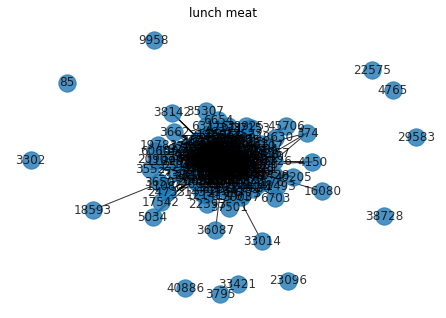

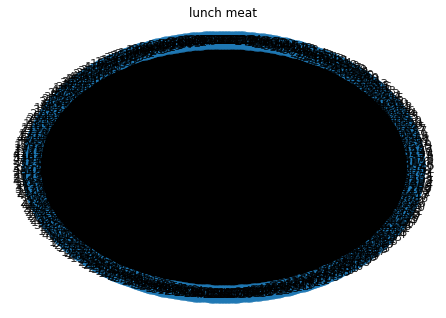

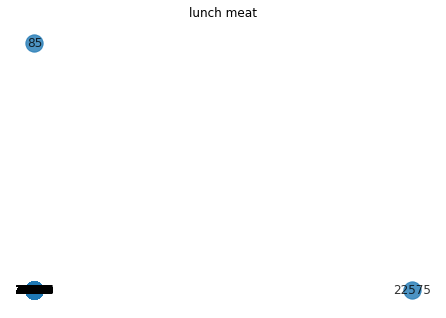

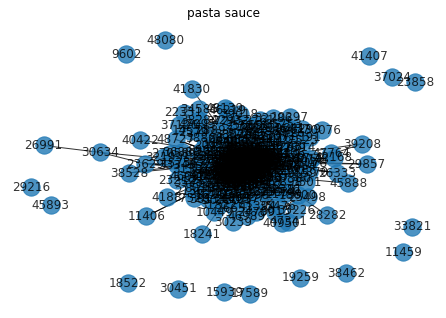

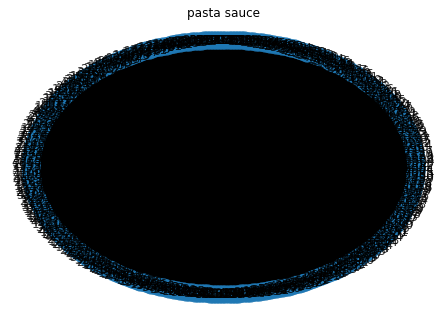

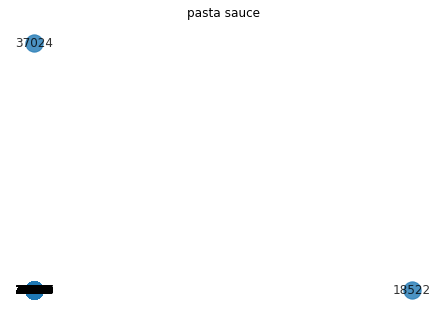

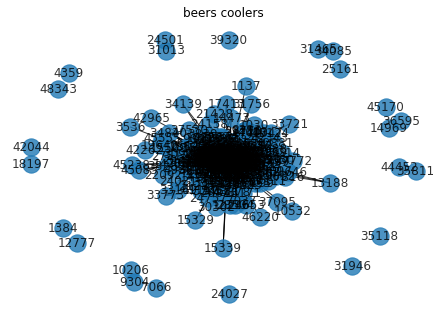

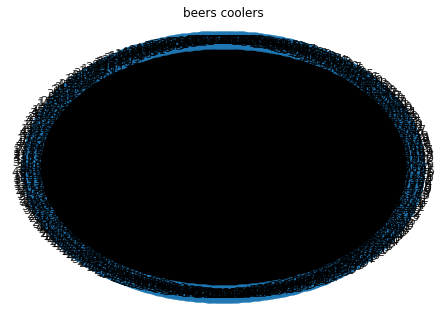

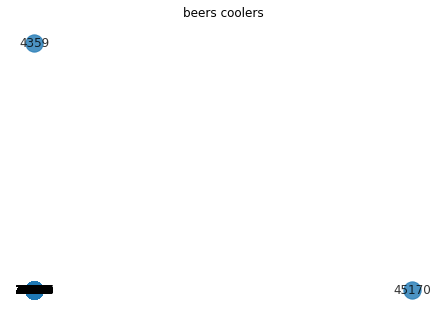

In [48]:
# just have a look
c=0
for aisle in food_aisles:
    c+=1
    if c>3:   # don't print all graphs, just a few
        break
    print('\n', aisle)
    G = nx.read_gpickle('prod_graphs_'+aisle+'.gpk')
    print(nx.info(G))
    plt.figure()
    nx.draw(G, with_labels=True,  alpha = 0.8)
    plt.title(aisle)
    plt.figure()
    nx.draw_circular(G, with_labels=True,  alpha = 0.8)
    plt.title(aisle)
    plt.figure()
    nx.draw_spectral(G, with_labels=True,  alpha = 0.8)
    plt.title(aisle)


We notice that these graphs are very dense. Therefore, it might be useful to remove small weight edges (if only very few users have bought a pair of products, they do not deserve to be linked).

Let's have a look at the edges weights:

In [49]:
def look_at_edges(G):
    edge_weights = [d['weight'] for (u, v, d) in G.edges(data=True)] # if d['weight'] < 200
    plt.figure()
    plt.hist(edge_weights, bins=100, log=True)
    print(np.quantile(edge_weights, [0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9, 0.99]))

[5.31914894e-03 7.04225352e-03 8.82879610e-03 1.37614679e-02
 2.19437415e-02 3.84615385e-02 1.57475658e-01 2.12200938e+00
 2.10494681e+02]
[4.04858300e-03 5.15463918e-03 6.19834711e-03 9.34579439e-03
 1.41509434e-02 2.12765957e-02 6.76106488e-02 5.80153139e-01
 2.82372198e+01]
[4.26829268e-03 6.23192149e-03 7.92682927e-03 1.33333333e-02
 2.17391304e-02 3.33333333e-02 1.06432881e-01 1.05930314e+00
 4.42571564e+01]
[4.73933649e-03 6.16525617e-03 7.53768844e-03 1.08304661e-02
 1.61290323e-02 2.43902439e-02 7.45544475e-02 5.92543336e-01
 3.99360617e+01]
[3.33333333e-03 4.21940928e-03 5.39568345e-03 8.31024931e-03
 1.26050420e-02 2.08333333e-02 7.00782269e-02 7.32172310e-01
 3.92081565e+01]
[3.18471338e-03 4.20168067e-03 5.23926335e-03 7.63358779e-03
 1.16279070e-02 1.86281395e-02 5.99187752e-02 5.04892249e-01
 1.42285601e+01]
[4.16666667e-03 5.44959128e-03 6.80272109e-03 1.02459016e-02
 1.55038760e-02 2.38095238e-02 7.14285714e-02 5.25636203e-01
 1.63859539e+01]


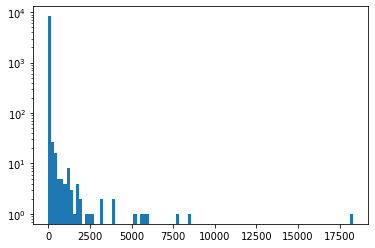

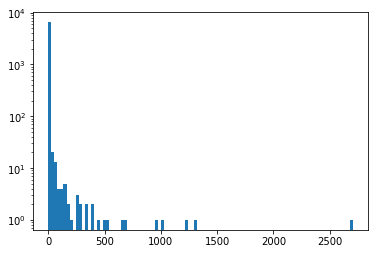

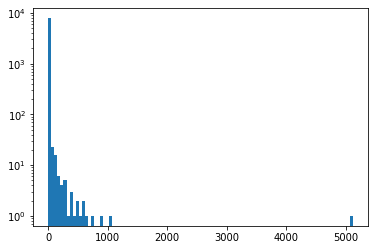

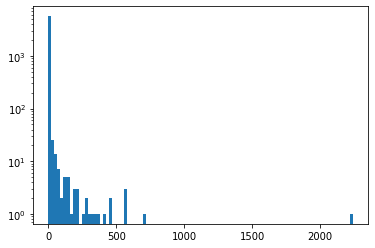

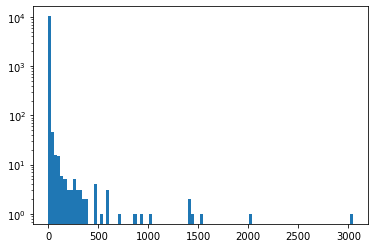

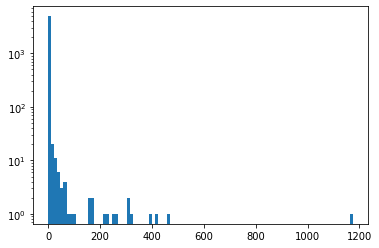

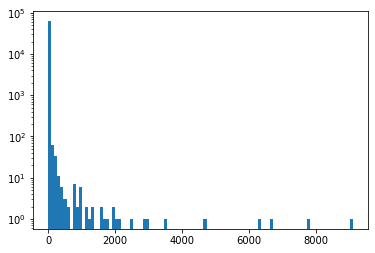

In [50]:
c=0
for aisle in food_aisles:
    c+=1
    if c>7:
        break
    look_at_edges(nx.read_gpickle('prod_graphs_'+aisle+'.gpk'))

The distribution of edges weights is extremely high on for very low weights. We choose to use the 30th percentile (_i.e._ remove the 30% lowest edges).

Define the function that, from a graph of products, removes the exceedingly numerous small edges (but reduces the percentile if too many products get disconnected from the graph). It also uses the inverse of the original weights as weights in order to enable looking for a shortest path.

In [51]:
def make_final_graph(G, aisle='None', threshold_quantile=0.3, verbose=False,save=False):
    print(aisle)
    edge_weights = [d['weight'] for (u, v, d) in G.edges(data=True)]
    lost = len(G)
    threshold_quantile = 2 * threshold_quantile
    stop = False
    threshold = 0
    while lost > 0.15 * len(G) and not stop:            # while too many nodes get disconnected, ...
        threshold_quantile = threshold_quantile / 2     # ... reduce percentile of edges removed
        new_threshold = np.quantile(edge_weights, threshold_quantile)
        if threshold == new_threshold:   # if reducing the percentile ceases to change the threshold, stop
            stop=True
        else:
            threshold = new_threshold
        thresholded_inv_edges = []
        C=0
        for (u, v, d) in G.edges(data=True):
            C+=1
            if d['weight'] > threshold: # select heavy enough eg-dges
                nd = d.copy()
                nd['weight'] = 1. / d['weight'] # use inverse of weight
                thresholded_inv_edges.append((u,v,nd))
        # make graph from selected edges:
        thresholded_inv = nx.Graph(thresholded_inv_edges)
        lost = len(G)-len(thresholded_inv)   # number of nodes that got disconnected
    print('Lost products: {} of {}'.format(len(G)-len(thresholded_inv), len(G)))
    print("Used quantile: {}".format(threshold_quantile))
    if verbose:
        print('Avg shortest Path:', shortest_paths.generic.average_shortest_path_length(thresholded_inv))
        print('Avg weighted shortest Path:', shortest_paths.generic.average_shortest_path_length(thresholded_inv, weight='weight'))
        print(nx.info(G))
        print(nx.info(thresholded_inv))
    if save:
        nx.write_gpickle(thresholded_inv, 'thresholded_inv_'+aisle+'.gpk')
    return thresholded_inv


Make the graphs to be used for product recommendation.

In [52]:
for aisle in food_aisles:
    make_final_graph(nx.read_gpickle('prod_graphs_'+aisle+'.gpk'), aisle, save=True)
    print('Done', aisle)
    print()

lunch meat
Lost products: 19 of 373
Used quantile: 0.3
Done lunch meat

pasta sauce
Lost products: 25 of 399
Used quantile: 0.3
Done pasta sauce

beers coolers
Lost products: 32 of 385
Used quantile: 0.3
Done beers coolers

frozen pizza
Lost products: 14 of 335
Used quantile: 0.3
Done frozen pizza

spreads
Lost products: 34 of 493
Used quantile: 0.3
Done spreads

grains rice dried goods
Lost products: 33 of 336
Used quantile: 0.3
Done grains rice dried goods

ice cream ice
Lost products: 38 of 1091
Used quantile: 0.3
Done ice cream ice

instant foods
Lost products: 32 of 543
Used quantile: 0.3
Done instant foods

red wines
Lost products: 19 of 232
Used quantile: 0.3
Done red wines

marinades meat preparation
Lost products: 49 of 409
Used quantile: 0.3
Done marinades meat preparation

coffee
Lost products: 46 of 680
Used quantile: 0.3
Done coffee

granola
Lost products: 15 of 185
Used quantile: 0.3
Done granola

trail mix snack mix
Lost products: 9 of 69
Used quantile: 0.3
Done trail mi

Make the function that, given a product (supposed not too healthy), outputs a recommended product (from the same aisle). The recommended product is selected among the 10 closest neighbours of the original product, based on a score taking into account distance to original, healthiness, and fidelity (~satisfaction) of consumers.

In [55]:
def find_recommendation_path(source_id, G=None, aisle=None, health_thresh=2, product_scores=None, hscores=None, fscores=None, alpha=.3, beta=.2):
    if G is None:
        G = nx.read_gpickle('thresholded_inv_'+aisle+'.gpk')
    if product_scores is None:
        product_scores = pd.read_pickle('product_scores')
        
    targets = set()
    for x in G.nodes:
        if x in product_scores.index and product_scores.at[x, "healthiness"] >= health_thresh:
            targets.add(x)
            
    # do not allow paths through even less healthy products:
    G_ok = G.subgraph({x for x in G.nodes if x in product_scores.index and product_scores.at[x, "healthiness"] >= product_scores.at[source_id, "healthiness"]})
    pred, lengths = nx.dijkstra_predecessor_and_distance(G_ok, source_id, weight='weight')
    candidates = [(-np.inf, None)]
    sep = []
    for candidate in targets:
        if candidate not in lengths:
            sep.append(candidate)
        if candidate in lengths and - lengths[candidate] > candidates[0][0]:   # ie candidate is closer than all current candidates
            if len(candidates) >= 10:
                hp.heappop(candidates)
            hp.heappush(candidates, (- lengths[candidate], candidate))
    #if fscores is None:
    #    fscores = pd.read_pickle('fidelity_scores.pk')
    if len(sep) == len(targets):
        print("not connected to a healthy product")
        return
    rec = (0, None)
    fids = []
    dists = []
    healths = []
    if candidates == [(-np.inf, None)]:
        print('No path to healthy products')
        return
    for (mdist, candidate) in candidates:
        if mdist == -np.inf:
            continue
        fids.append(product_scores.at[candidate, 'fidelity'])
        dists.append(- mdist)
        healths.append(product_scores.at[candidate, 'healthiness'])
    max_fid = max(fids)
    min_fid = min(fids)
    max_dist = max(dists)
    min_dist = min(dists)
    max_health = max(healths)
    min_health = min(healths)
    for (mdist, candidate) in candidates:
        if mdist == -np.inf:
            continue
        fid = ((product_scores.at[candidate, 'fidelity'] - min_fid) / (max_fid - min_fid)) if max_fid != min_fid else 0
        dist = ((max_dist + mdist) / (max_dist - min_dist)) if max_dist != min_dist else 0
        health = ((product_scores.at[candidate, "healthiness"] - min_health) / (max_health - min_health)) if max_health != min_health else 0
        score = (1+health)**alpha * (1+fid)**beta * (1+dist)**(1-alpha-beta)
        if score > rec[0]:
            rec = (score, candidate)
    orig = rec[1]
    path = [orig]
    while orig != source_id:
        orig = pred[orig][0]
        path.append(orig)
    return path

### Recommend products

Let's find some real recommendations for some products that users from the cluster 0 (considered the least healthy) have made.

We first need to import and re-index the dataframe containing the healthiness and fidelity scores of each product:

In [56]:
product_scores = pd.read_pickle('product_scores')
product_scores.columns=['healthiness', 'count', 'fidelity']
product_scores.set_index(product_scores.index.astype(int)).to_pickle('product_scores.pk')
product_scores = pd.read_pickle('product_scores.pk')

In [57]:
prod_lit = products_litteral.set_index('product_id')
prod_lit.head()

,product_name,aisle,department
product_id,,,
1,Chocolate Sandwich Cookies,cookies cakes,snacks
78,Nutter Butter Cookie Bites Go-Pak,cookies cakes,snacks
102,Danish Butter Cookies,cookies cakes,snacks
172,Gluten Free All Natural Chocolate Chip Cookies,cookies cakes,snacks
285,Mini Nilla Wafers Munch Pack,cookies cakes,snacks


Get orders from "unhealthy" users:

In [58]:
orders_products = pd.read_pickle('orders_products.pk')
with open('users_cluster.pk', 'rb') as f:
    users_cluster = pk.load(f)
unhealthy = set(u+1 for u in range(len(users_cluster)) if users_cluster[u]==0)
unhealthy_orders = orders_products[orders_products.user_id.isin(unhealthy)]
unhealthy_food_orders = unhealthy_orders[unhealthy_orders.apply(lambda row: prod_lit.at[row.product_id, 'aisle'] in food_aisles, axis=1)]

Sample some orders:

In [59]:
some_unhealthy_orders = unhealthy_orders.sample(100)[['order_id', 'user_id', 'product_id']]

In [60]:
some_unhealthy_orders.head()

,order_id,user_id,product_id
2397779,281097,34602,36011
12021746,1248953,173452,35221
13331798,378461,192282,44923
9864052,348628,142174,38374
707047,630312,10374,26620


Find recommendations for selected orders:

In [61]:
for _, row in some_unhealthy_orders.iterrows():
    try:
        print('For user ', row.user_id)
        print('Path from', prod_lit.at[row.product_id, 'product_name'], 'with healthiness', product_scores.at[row.product_id, 'healthiness'])
        path = find_recommendation_path(row.product_id, aisle=prod_lit.at[row.product_id, 'aisle'], product_scores=product_scores)
        target = path[-1]
        print('To', prod_lit.at[target, 'product_name'], 'with healthiness', product_scores.at[target, 'healthiness'])
        if len(path)>2:
            print('Through', ', then'.join([prod_lit.at[path[i], 'product_name'] for i in range(1, len(path)-1)]))
        print()
    except:
        print('============================= Echec: For user ', row.user_id)
        print('Path from', prod_lit.at[row.product_id, 'product_name'], 'with healthiness', product_scores.at[row.product_id, 'healthiness'])
        print()
        

For user  34602
Path from Organic Fat Free Milk with healthiness 0.528167115902965
To Organic Fat Free Milk with healthiness 0.528167115902965
Through 2% Reduced Fat Milk, thenFat Free Milk

For user  173452
Path from Lime Sparkling Water with healthiness 0.7841737781225756
To Lime Sparkling Water with healthiness 0.7841737781225756
Through Passionfruit Sparkling Water, thenOrange Sparkling Water

For user  192282
Path from Zesty Lemon Sorbet with healthiness 1.968586387434555
To Zesty Lemon Sorbet with healthiness 1.968586387434555
Through Caramel Cone Ice Cream

For user  142174
Path from Milk and Cookies Ice Cream with healthiness 0.8463726884779517
To Milk and Cookies Ice Cream with healthiness 0.8463726884779517
Through Vanilla Milk Chocolate Almond Ice Cream Bars Multi-Pack, thenVanilla Ice Cream, thenChocolate Chip Cookie Dough Ice Cream

For user  10374
Path from Peach Pear Flavored Sparkling Water with healthiness 0.7945991561181435
To Peach Pear Flavored Sparkling Water with 

To Sparkling Lemon Water with healthiness 0.9362713329012746
Through Passionfruit Sparkling Water, thenOrange Sparkling Water

For user  171897
Path from Water Mineral with healthiness 2.7305863708399367
To Water Mineral with healthiness 2.7305863708399367

For user  155537
Path from Soda with healthiness 3.111983096891035
To Soda with healthiness 3.111983096891035

For user  192375
Path from The Original Worcestershire Sauce with healthiness 0.24924471299093656
To The Original Worcestershire Sauce with healthiness 0.24924471299093656
Through Original Hot Sauce, thenTomato Ketchup

For user  174234
Path from Coconut Sparkling Water with healthiness 1.977189781021898
To Coconut Sparkling Water with healthiness 1.977189781021898
Through Lemon Sparkling Water

For user  52376
Path from Beef & Bean Green Chili Burritos with healthiness 3.3513513513513513
To Beef & Bean Green Chili Burritos with healthiness 3.3513513513513513

For user  150140
Path from Organic Large Brown Grade AA Cage Fre

To Roasted Dandelion Spice Detox Tea with healthiness 0.3508771929824561
Through Earl Grey Tea, thenZen Tea, thenGinger Tea, thenLemon Ginger Tea Bags

For user  56420
Path from Grapefruit Sparkling Water with healthiness 1.9043285784554844
To Grapefruit Sparkling Water with healthiness 1.9043285784554844

For user  157970
Path from Honey Turkey with healthiness 0.9130434782608695
To Honey Turkey with healthiness 0.9130434782608695
Through Deli Fresh Honey Ham, 97% Fat Free, Gluten Free, thenHard Salami, thenTurkey

For user  36617
Path from Peach Pear Flavored Sparkling Water with healthiness 0.7945991561181435
To Peach Pear Flavored Sparkling Water with healthiness 0.7945991561181435
Through Passionfruit Sparkling Water, thenOrange Sparkling Water, thenSparkling Lemon Water

For user  199586
Path from Instant, Irish Oatmeal, Maple & Brown Sugar with healthiness 0.4296875
To Instant, Irish Oatmeal, Maple & Brown Sugar with healthiness 0.4296875
Through Cinnamon & Spice Instant Oatmeal

In [62]:
# Prints some good and bad examples of predictions

good_product_ids = [8923,16419,4313,12218,516]
bad_product_ids = [28199,6184, 14809]

print("Good recommendation examples : ")
for p in good_product_ids :
    target = find_recommendation_path(p, aisle=prod_lit.at[p, 'aisle'], product_scores=product_scores)[0]
    s = prod_lit.at[p, 'product_name']+' should be replaced by '+ prod_lit.at[target, 'product_name']+ ' (healthiness gain = '+str (round(product_scores.at[target, 'healthiness']-product_scores.at[p, 'healthiness'],2))+")"
    print(s)
    
print("\nBad or strange recommendation examples : ")
for p in bad_product_ids :
    try:
        target = find_recommendation_path(p, aisle=prod_lit.at[p, 'aisle'], product_scores=product_scores)[0]
        s = prod_lit.at[p, 'product_name']+' should be replaced by '+ prod_lit.at[target, 'product_name']+ ' (healthiness gain = '+str (round(product_scores.at[target, 'healthiness']-product_scores.at[p, 'healthiness'],2))+")"
        print(s)
    except:
        print("Failure")

Good recommendation examples : 
Chocolate Milk Cartons 2% Reduced Fat should be replaced by Chocolate Milk Cartons 2% Reduced Fat (healthiness gain = 0.0)
Sweet Sliced Bread should be replaced by Sweet Sliced Bread (healthiness gain = 0.0)
Star Wars Italian Sweet Creme Creamer should be replaced by Hazelnut Coffee Creamer (healthiness gain = 0.39)
Classic Wheat Bread should be replaced by Large Enriched Bread (healthiness gain = 0.3)
American Cheese Slices should be replaced by Deli Sliced Sharp Cheddar Cheese (healthiness gain = 0.86)

Bad or strange recommendation examples : 
Clementines, Bag should be replaced by Baby Carrots (healthiness gain = 1.85)
not connected to a healthy product
Failure
Organic Earl Grey Black Tea Bags 15 Count should be replaced by Chai Classic Tea (healthiness gain = 2.01)


It is worth noticing that many times, an organic product is recommended instead of a non-organic product.

# Amazon dataset: product matching is too uncertain to be usefull

**Amazon dataset** : _metadata_ and _reviews_ of Grocery and Gourmet Food products : https://cseweb.ucsd.edu/~jmcauley/datasets.html?fbclid=IwAR39s5O83nqUYkRBD4jol3OFu0FmcH-4dCzUtSjutOsmSd9LMZOHSGGtNxw#amazon_reviews


To get some more qualitative informations on our Instacart products (e.g. price, quality, etc.), we tried to incorporate informations from the Amazon dataset. 

We have noticed that some Instacart product names are way too vague (e.g. "water") to be matched precisely to an Amazon product. Moreover, Instacart product names are more generally less precise than Amazon names, without mentionning the brand for instance. Therefore we cannot be sure to match identical products.

In order to match products as precisely as possible, we matched an Instacart product to an Amazon product if and only if:
* the Amazon name contains all the words of the Instacart name,
* only one Amazon product satisifes the previous condition (otherwise we suppose the Instacart name is too broad). 

After we performed the merge, we found that 10456 products were matched, but some were inaccurate (_eg_, "Can Opener" matched to "Wall Can Crusher With Bottle Opener", or "Apple Pineapple Bar" matched to "That's It Bar,6 Flavor Sampler,Variety pack of 24 (4 Apple+Apricot , 4 Apple+Strawberry ,4 Apple+ Blueberry, 4 Apple+ Coconut, 4 Apple+ Cherry, 4 Apple+ Pineapple), BONUS!! 2 BAG CLIPS FREE"). Also, there was no guarantee that, even when the name seemed to match, products were exactly identical (including weight, which greatly influences price... We thus decided that this sparse and uncertain match would not be informative, and we relinquished the plan to use this dataset. We also thought of matching aisle by aisle instead of product per product, but we decided we could not extract any useful information from such a rough match.

In [ ]:
res = pd.read_csv('ADAX/unique_matches0_translated.csv')
res.head()

,product_name,title
0,Fresh Marinara Sauce,Vino de Milo No Sugar Added Pasta Sauce (16 oz...
1,Blonde Veranda Blend Whole Bean Coffee,Starbucks Veranda Blend Light Blonde Roast Who...
2,Can Opener,Wall Can Crusher With Bottle Opener
3,French Vanilla Powder Coffee Creamer,Coffee-mate Products - Coffee-mate - French Va...
4,Mac And Cheese,Annie's Homegrown Low Sodium Natural Mac And C...


This complex merge had to be run on the cluster. Below is the script that we used to make this merge.

In [ ]:
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.functions import udf
from pyspark.sql.types import LongType
from pyspark.sql.functions import split
import pyspark.sql as sql
import pyspark.sql.functions as F
from pyspark import SparkContext

# create Spark session
spark = sql.SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sc.setLogLevel("WARN")


products = spark.read.csv('ADAX/data/products.csv', sep=',', header=True)
aisles = spark.read.csv('ADAX/data/aisles.csv', sep=',', header=True)
departments = spark.read.csv('ADAX/data/departments.csv', sep=',', header=True)
orders = spark.read.csv('ADAX/data/orders.csv', sep=',', header=True)

print("Loaded all\n\n")

products_litteral = products.join(aisles, 'aisle_id').join(departments, 'department_id').drop('aisle_id', 'department_id')

print("Joined for litterals\n\n")


# read Amazon data
Amazon_meta = spark.read.json("ADAX/data/meta_Grocery_and_Gourmet_Food.json.gz")


# adn retain only useful columns
Amazon_meta_light = Amazon_meta.drop('also_view','description','details','feature','fit', 'image','similar_item', 'tech1')


Amazon_meta_light.printSchema()


Amazon1=Amazon_meta_light
Amazon1 = Amazon1.filter(~F.col('title').contains('{'))


# move Instacart data to Spark as well
products_lit_spark = products_litteral
products_lit_spark = products_lit_spark.withColumn('product_name', F.regexp_replace('product_name', '\\\"', ''))


products_lit_spark.count()

# define a udf to return the set of words contained in a product name
words_udf = udf(lambda x: list(set(re.compile("\\W+").split(x))), sql.types.ArrayType(sql.types.StringType()))


# create the lists of words contained in the amazon product name ('title')
Amazon_title_as_words = Amazon1.withColumn('title_words', words_udf('title'))
print('Amazon products:', Amazon_title_as_words.count())
print()
print()
print('--'*80)

# remove duplicates
Amazon_title_as_words = Amazon_title_as_words.withColumn('str_wds', F.col('title_words').cast('string'))
Amazon_title_as_words = Amazon_title_as_words.dropDuplicates(subset=['str_wds']).drop('str_wds')
print('Using {} Amazon products'.format(Amazon_title_as_words.count()))
print()
print()
print('--'*80)

#Amazon_title_as_words = reload('Amazon_title_as_words.parquet', Amazon_title_as_words)
for row in Amazon_title_as_words.take(10):
    print(row.title_words)

# create the lists of words contained in the instacart product name ('title')
products_words = products_lit_spark.withColumn('name_words', words_udf('product_name'))
print('Insta products:', products_words.count())
print()
print()
print('--'*80)

# remove duplicates
products_words = products_words.withColumn('str_wds', F.col('name_words').cast('string'))
products_words = products_words.dropDuplicates(subset=['str_wds']).drop('str_wds')
print('Using {} Instacart products'.format(products_words.count()))
print()
print()
print('--'*80)



# define udf to filter one-word product names
len_filter = udf(lambda x: len(x) <= 1, sql.types.BooleanType())


# keep only products whose name contains more than one word
real_products = products_words.filter(~len_filter('name_words'))
#real_products = reload('real_products.parquet', real_products)
# real_products.show()


Amazon_expl = Amazon_title_as_words.withColumn('title_word', F.explode('title_words'))
#Amazon_expl = reload('Amazon_expl.parquet', Amazon_expl)


products_expl = real_products.withColumn('name_word', F.explode('name_words'))
#products_expl = reload('products_expl.parquet', products_expl)


# join on identiacal words
df_withwords = Amazon_expl.join(products_expl, Amazon_expl.title_word==products_expl.name_word)
#df_withwords = reload('df_withwords.parquet', df_withwords)
# df_withwords.show()


# now group by both names and count words in common
regrouped = df_withwords.groupBy(['product_name', 'title']).agg(F.count('title_word').alias('nb_common_words'), F.collect_set('name_words').getItem(0).alias('name_words'))
#regrouped = reload('regrouped.parquet', regrouped)
# regrouped.show()


# this function tests whether all the words of the Instacart name are found in the Amazon name (i.e. the number of words in common is equal to the number of words of the Instacart name)
full_match_udf = udf(lambda nb, name_words: len(name_words)==nb, sql.types.BooleanType())

# keep only products whose Instacart name's words are all found in the Amazon name
full_match = regrouped.filter(full_match_udf('nb_common_words', 'name_words'))
#full_match = reload('full_match.parquet', full_match)
# full_match.show()
for row in full_match.take(100):
    print(row.product_name, ': ', row.title, '\n', row.name_words, ' |-| ', row.nb_common_words, '\n'+'_'*100+'\n')


# now group by Instacart product and count the number of matching Amazon products
full_matches = full_match.groupBy('product_name').agg(F.collect_list('title').alias('titles'), F.count('title').alias('nb_titles'))
#full_matches = reload('full_matches.parquet', full_matches)
# full_matches.show()
for row in full_matches.take(100):
    print(row.product_name, ': ', row.titles, '\n')


# now retain only Instacart products with no more than one amazon match
unique_match = full_matches.filter(len_filter('titles')).withColumn('title', F.col('titles').getItem(0)).drop('titles', 'nb_titles')
#unique_match = reload('unique_match.parquet', unique_match)
for row in unique_match.take(100):
    print(row.product_name, ': ', row.title, '\n')

print('Unique matches', unique_match.count())
print()
print()
print('--'*80)

i = 0
while True:
    try:
        unique_match.coalesce(1).write.format("com.databricks.spark.csv").option("header", "true").save('ADAX/unique_matches{}.csv'.format(i))
        print('Saved with index {}'.format(i))
        break
    except:
        i += 1
